## Spectral Clustering and Semi-Supervised Learning

#### This notebook contains different values and imports that can be used in this practical session.
#### Please keep the same variable names when provided in your report to make the work of teaching assistants easier. 
#### You can still change the values given or the sizes of the datasets treated if you believe it is usefull to illustrate your point.

#### You can directly edit the markdown boxes to add your comments and answers to the questions

In [1]:
# Question 1 (imports and advised values):
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import warnings
from sklearn.datasets import load_breast_cancer, load_digits
from sklearn.model_selection import train_test_split
warnings.simplefilter('ignore')
n_samples = 500 # You can change these values
noise_level_list = [.05,.1,.2] # You can change these values

### Question 1 : Complete the code in the box below

we generate a few dataset with the levels of noise given above and we plot them 

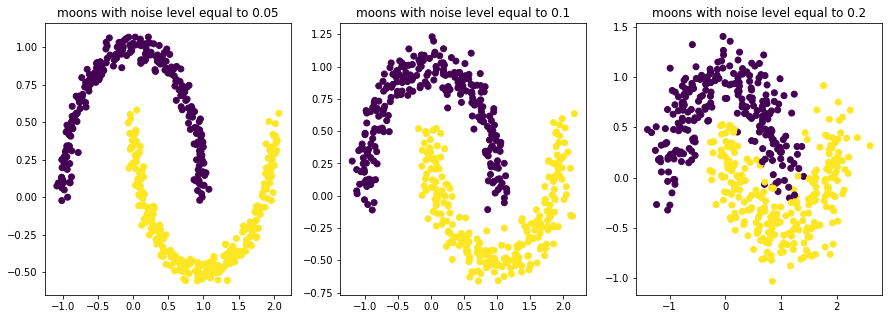

In [10]:
noisy_moons_1 = make_moons(n_samples=n_samples, noise=.05)
noisy_moons_2 = make_moons(n_samples=n_samples, noise=.1)
noisy_moons_3 = make_moons(n_samples=n_samples, noise=.2)

figure = plt.figure(figsize=(15,5))

axes = figure.add_subplot(1, 3, 1)
axes.scatter(noisy_moons_1[0][:,0], noisy_moons_1[0][:,1], marker='o', c=noisy_moons_1[1])
axes.set_title("moons with noise level equal to 0.05")

axes = figure.add_subplot(1, 3, 2)
axes.scatter(noisy_moons_2[0][:,0], noisy_moons_2[0][:,1], marker='o', c=noisy_moons_2[1])
axes.set_title("moons with noise level equal to 0.1")

axes = figure.add_subplot(1, 3, 3)
axes.scatter(noisy_moons_3[0][:,0], noisy_moons_3[0][:,1], marker='o', c=noisy_moons_3[1])
axes.set_title("moons with noise level equal to 0.2")    

In [2]:
# Question 2 :
from sklearn.neighbors import kneighbors_graph
n_neighbors_list = [1,5,10,20,40] # You can change these values

### Question 2 : Complete the code in the box below

we build the graphs for different values of neighbors and we use the netwotkx library to then plot the graph.
each line has the same level of noise and each column has the same number of neighbors.

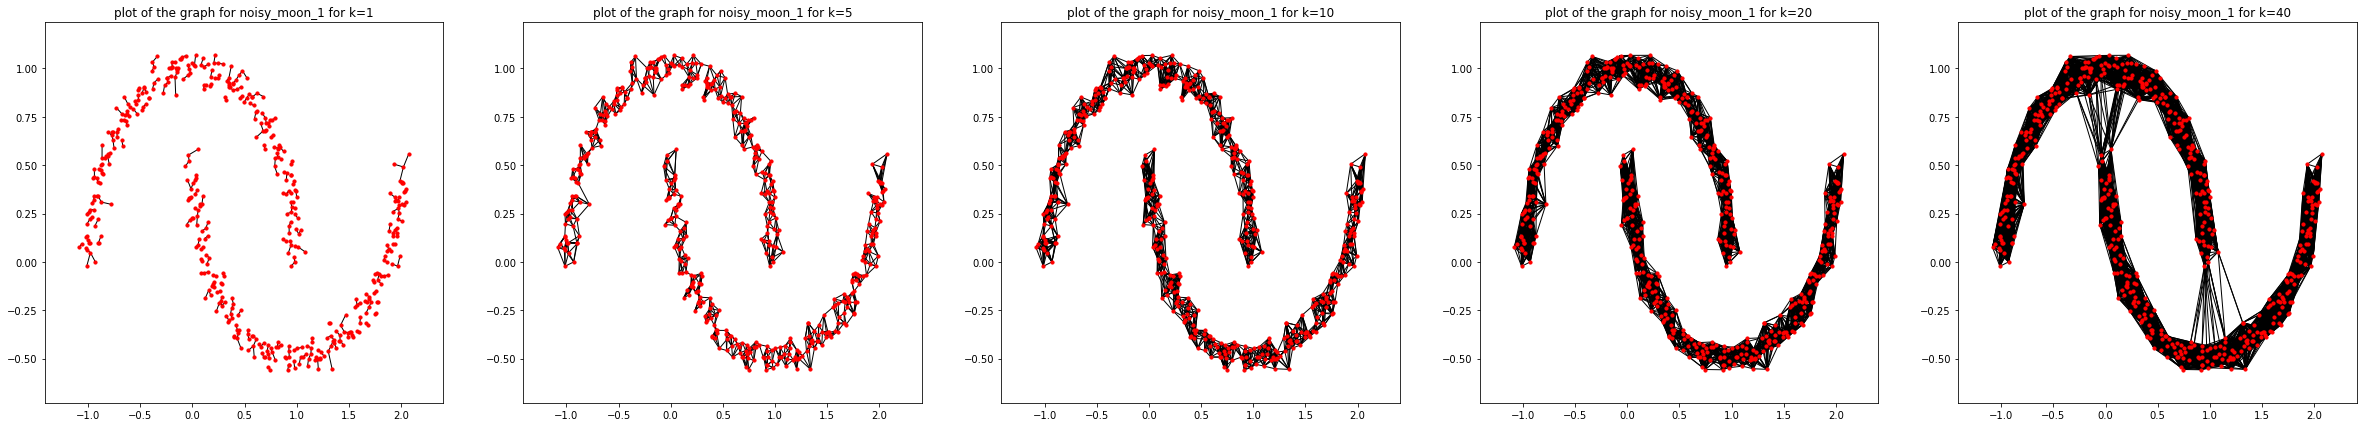

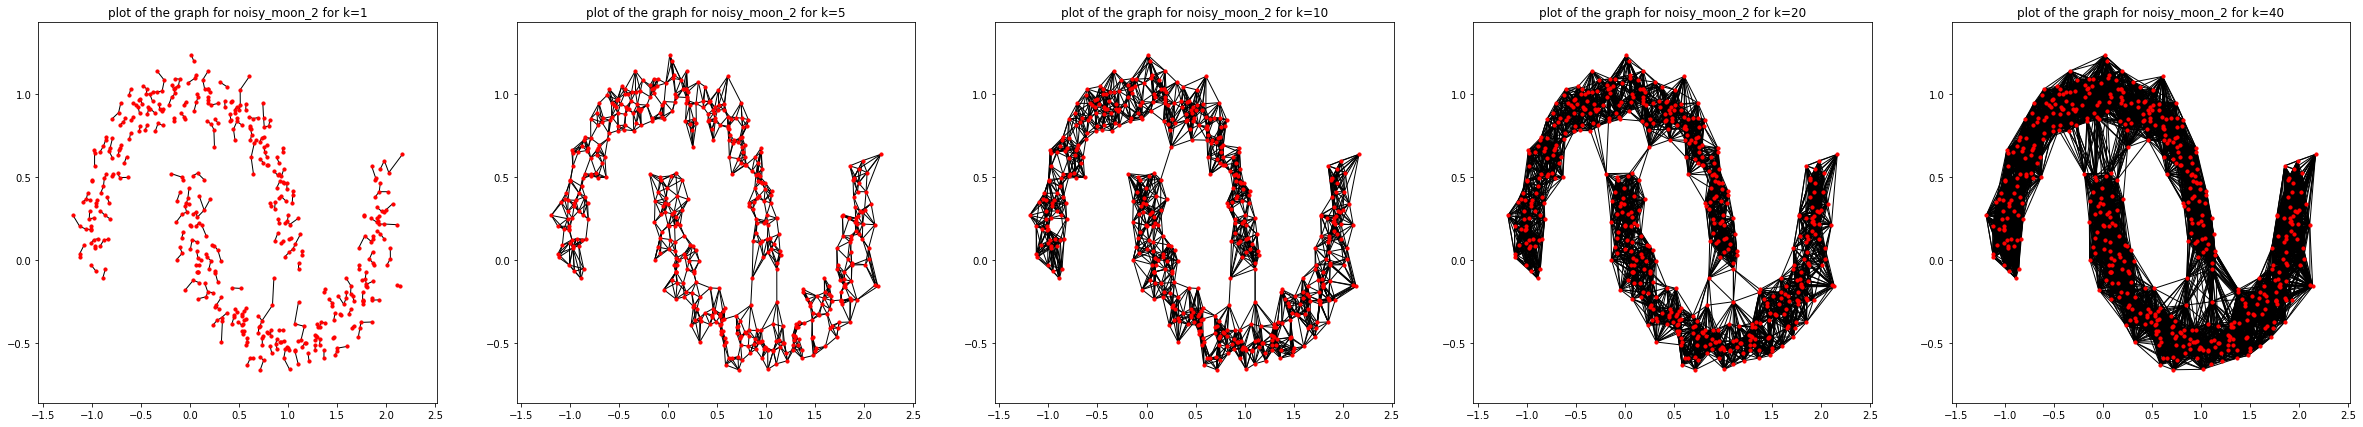

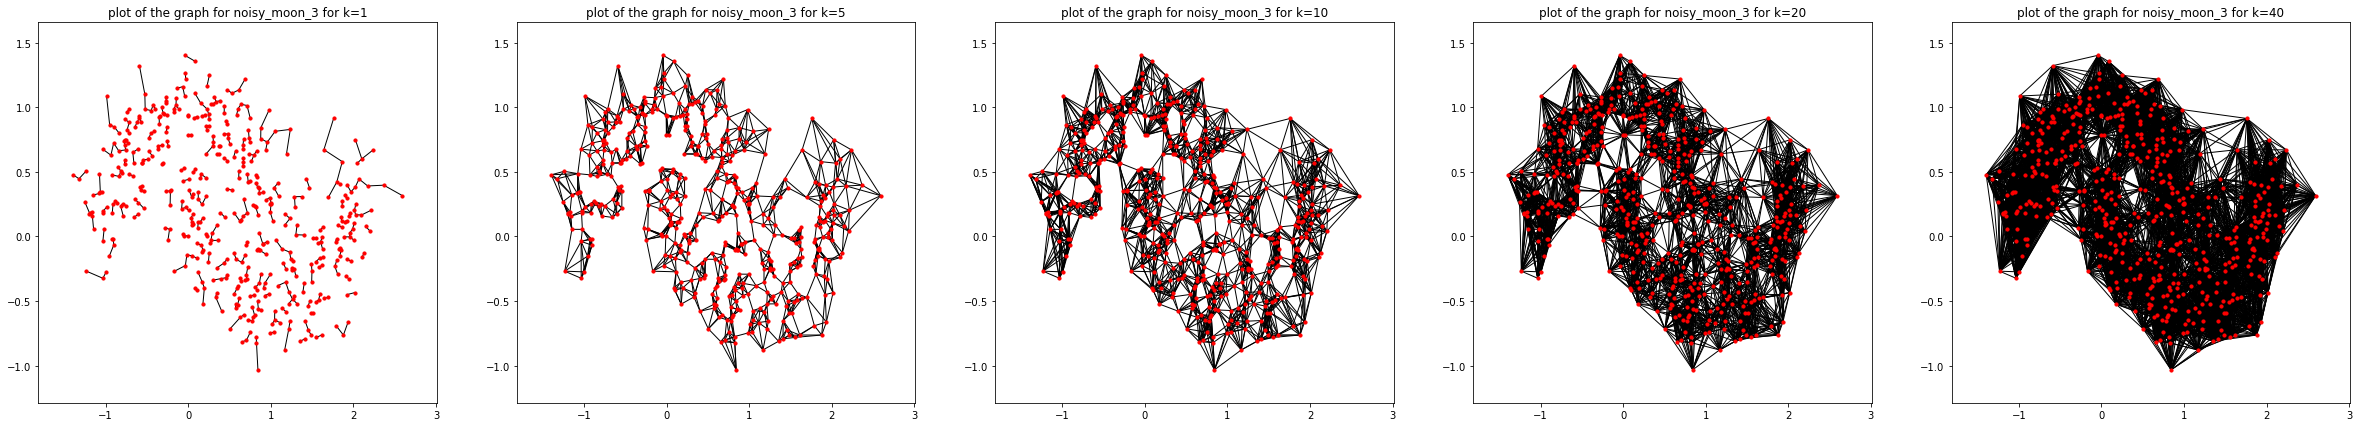

In [11]:
import matplotlib.pyplot as plt
import networkx as nx

fig = plt.figure(figsize=(50,7)) 
for j,noisy_moons in enumerate([noisy_moons_1,noisy_moons_2,noisy_moons_3]):
    fig = plt.figure(figsize=(50,7)) 
    for k,i in enumerate(n_neighbors_list):
        plt.subplot(1, len(n_neighbors_list)+1, k+1)
        G = nx.from_numpy_matrix(np.array(kneighbors_graph(noisy_moons[0],i).toarray()))
        pos = {i:(noisy_moons[0][i][0],noisy_moons[0][i][1]) for i in range(len(noisy_moons[0]))}
        nx.draw_networkx(G,pos,with_labels=False,node_size=10)
        plt.title("plot of the graph for noisy_moon_"+str(j+1)+" for k="+str(i))
    
    plt.show()
        

### Question 3 : Optimization problem 

The optimization problem leading to the Normalized-cut Spectral Clustering is :
$$
(2) = \left\{
    \begin{array}{ll}
        \underset{f \in \mathbb{R}^n}{\text{min}}~ \frac{f^T Lf}{f^T Df} \\
       \text{subject to}~ f^T D1_n = 0
    \end{array}
\right.
$$
with:  
 W the adjacency matrix  
 D the degree matrix : $d_{ii} = \sum_{j}w_{ij},~if~i \neq j ~ d_{ij}=0$  
 The unnormalized Laplacian $L = D - W$  
 The normalized Laplacian $L_{sym} = D^{-1/2}(D - W)D^{-1/2}$, $L_{rw} = D^{-1}(D - W)$  


### Question 4 : Complete the code in the box below

we now run the two-ways spectral clustering algorithm of Scikit-learn and we visualize the results in a 2D graph.

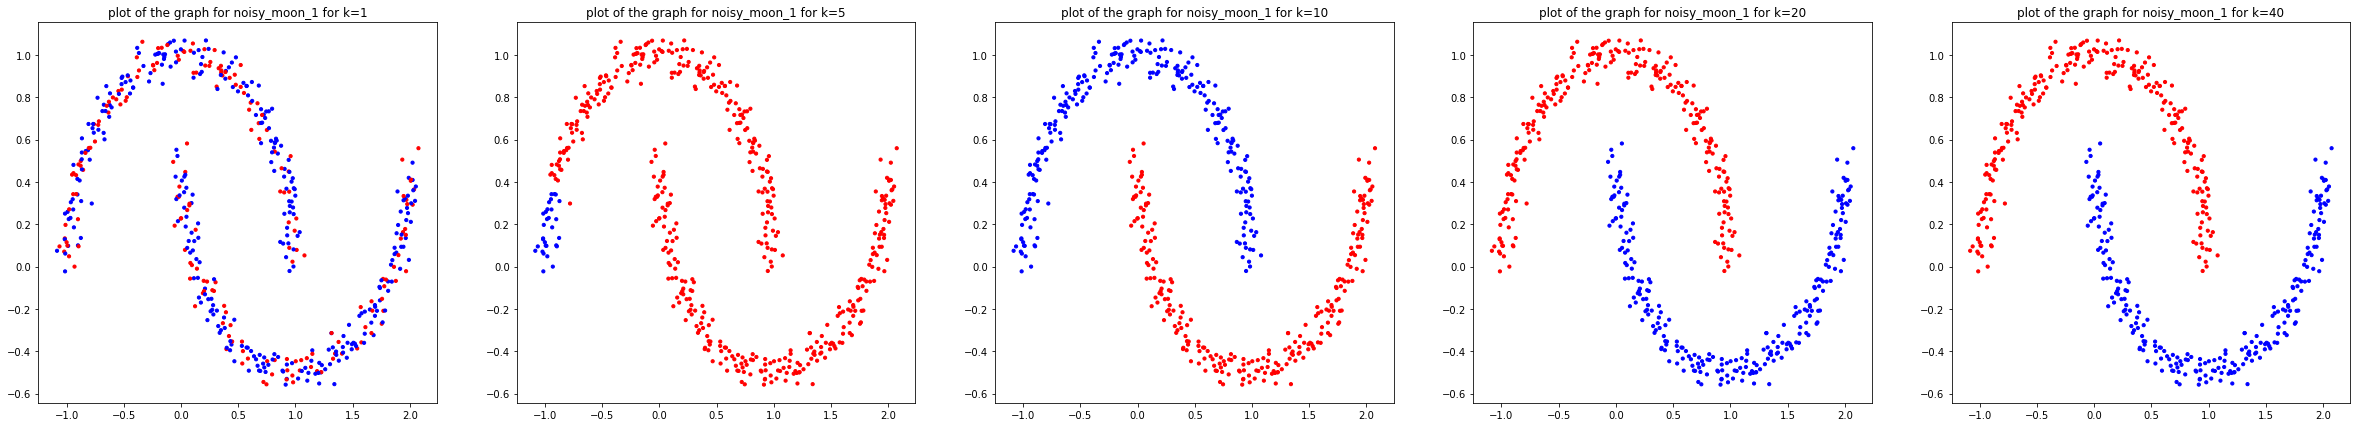

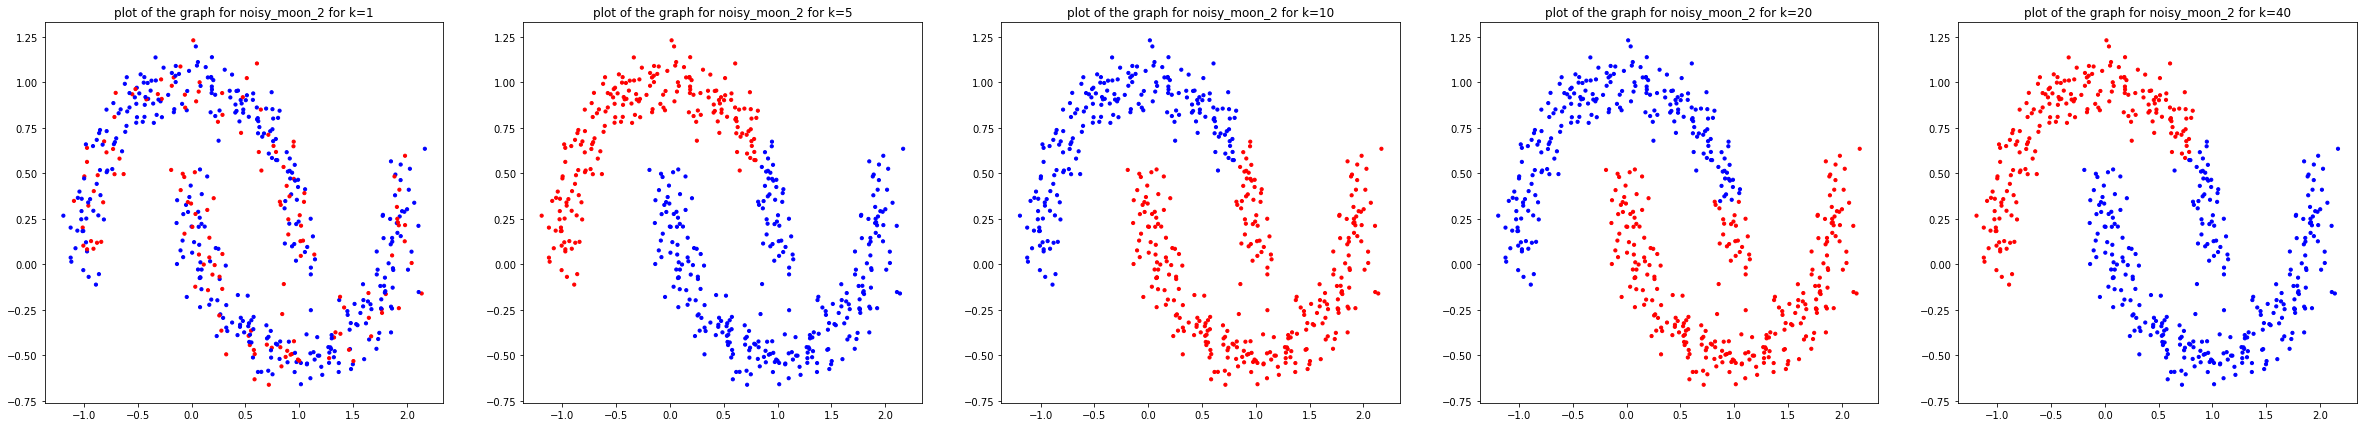

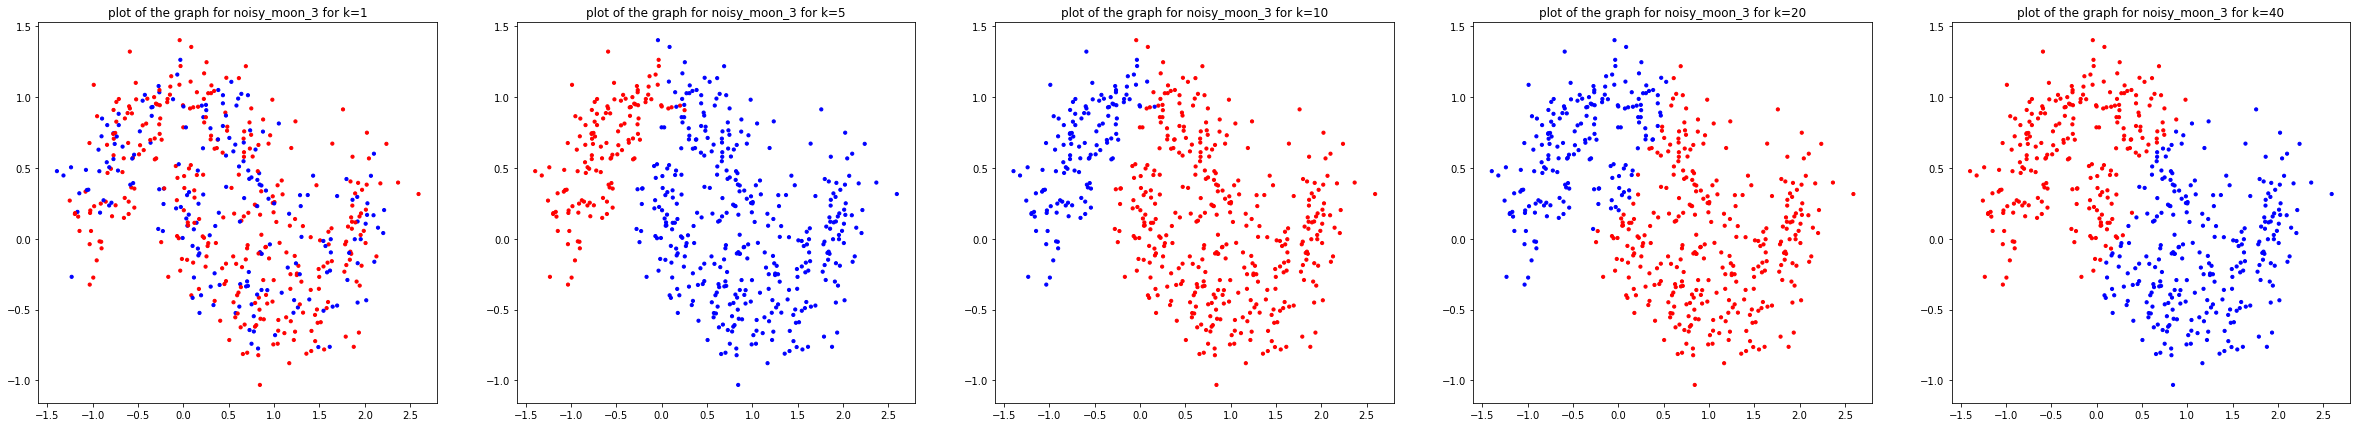

In [12]:
from sklearn.cluster import SpectralClustering

colors = ['r','b']
fig = plt.figure(figsize=(50,7)) 
for j,noisy_moons in enumerate([noisy_moons_1,noisy_moons_2,noisy_moons_3]):
    fig = plt.figure(figsize=(50,7))
    for k,i in enumerate(n_neighbors_list):
        ax = plt.subplot(1, len(n_neighbors_list)+1, k+1)
        X = noisy_moons[0]
        spectral = SpectralClustering(n_clusters=2,affinity="nearest_neighbors",n_neighbors = i) #we recompute the proxi matrix
        y_pred = spectral.fit_predict(X)
        color = ['r' if y == 0 else 'b' for y in y_pred]
        ax.scatter(X[:, 0], X[:, 1], s=10, color=color)
        ax.set_title("plot of the graph for noisy_moon_"+str(j+1)+" for k="+str(i))
    plt.show()
         

we observe that for k=1 in every case the adjancy matrix doesn't give enough information and the two classes are completly mixed up. 
For more important values of k, we find more relevant graphs: For a low level of noise, we obtain perfect result for k=10, for others, the tip of of one of the moons (or both) is not in the right class and that not matter what value we take for k.


### Question 5 : Complete the code in the box below

In [13]:
#implementation of the stability methode for Spectral Clustering
def stabilitymethode(dataset,B,C,b_rate = 0.8,k=10):
        Mat = []
        ##### generation of the y_proba with full datatset #####
        X = dataset
        connectivity = kneighbors_graph(X, n_neighbors=k, include_self=False)
        spectral = SpectralClustering(n_clusters=C,affinity="precomputed")
        spectral.fit(connectivity)
        y_pred_all = spectral.labels_.astype(np.int)
        #### loop to get B tests ######
        for i in range(B):
            #### random generation of what we will for the test ####
            dx_tmp = np.random.choice(X.shape[0], int(b_rate * X.shape[0]), replace=False)
            #### predict the class for the undersample ####
            X_boostrap = [X[idx,:] for idx in dx_tmp]
            connectivity = kneighbors_graph(X_boostrap, n_neighbors=k, include_self=False)
            spectral = SpectralClustering(n_clusters=C,affinity="precomputed")
            spectral.fit(connectivity)
            y_pred_boostrap = spectral.labels_.astype(np.int)
            ###### build the matrice C #####
            y_pred_cut = [y_pred_all[idx] for idx in dx_tmp]
            partition_matrix = [[1 if y_pred_a == y_pred_b else 0 for y_pred_a in y_pred_boostrap] for y_pred_b in y_pred_boostrap]
            partition_matrix_all = [[1 if y_pred_a == y_pred_b else 0 for y_pred_a in y_pred_cut] for y_pred_b in y_pred_cut]
            Mat.append([partition_matrix,partition_matrix_all])
        #### having all the partition matrix we now multplie them all to get the similarity ####
        A =[sum(sum(np.multiply(mat[0], mat[1])))/(np.linalg.norm(mat[0],'fro')*np.linalg.norm(mat[1],ord='fro')) for mat in Mat] 
        return A


### Question 6 : Complete the code in the box below

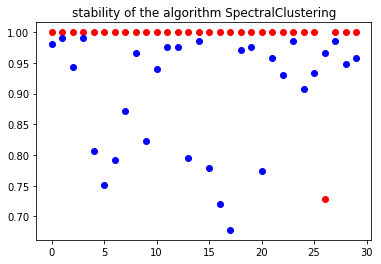

In [16]:
#first test 
plt.plot(stabilitymethode(noisy_moons_1[0],30,2),'ro')
plt.plot(stabilitymethode(noisy_moons_3[0],30,2),'bo')
plt.title("stability of the algorithm SpectralClustering")

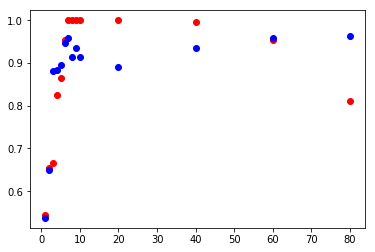

In [15]:
#we now try to find the best k for c=2
K = [1,2,3,4,5,6,7,8,9,10,20,40,60,80]
mean_1 = []
mean_3 = []
for k in K:
    mean_1.append(np.mean(stabilitymethode(noisy_moons_1[0],30,2,k=k)))
    mean_3.append(np.mean(stabilitymethode(noisy_moons_3[0],30,2,k=k)))

#and we plot:
plt.plot(K,mean_1,'ro',K,mean_3,'bo')

the graph above helps us to determine for C=2 wich region of k we should explore to find the best efficiency for our algorithm.
Here we see that around k=10 we have a realy stable algorithm for both datasets (above 0.9 of stability). It indeed helped us choose k for C=2

### Question 7 : Complete the code in the box below

In [16]:
from sklearn.cluster import AgglomerativeClustering

def stabilitymethode2(dataset,B,C,b_rate = 0.8,k=10,linkage="ward"):
        Mat = []
        ##### generation of the y_proba with full datatset #####
        X = dataset
        connectivity = kneighbors_graph(X, n_neighbors=k, include_self=False)
        agglomerative = AgglomerativeClustering(n_clusters=C,connectivity=connectivity,linkage=linkage)
        y_pred_all = agglomerative.fit_predict(X)
        #### loop to get B tests ######
        for i in range(B):
            #### random generation of what we will for the test ####
            dx_tmp = np.random.choice(X.shape[0], int(b_rate * X.shape[0]), replace=False)
            #### predict the class for the undersample ####
            X_boostrap = [X[idx,:] for idx in dx_tmp]
            connectivity = kneighbors_graph(X_boostrap, n_neighbors=k, include_self=False)
            agglomerative = AgglomerativeClustering(n_clusters=C,connectivity=connectivity,linkage=linkage)
            y_pred_boostrap = agglomerative.fit_predict(X_boostrap)
            ###### build the matrice C #####
            y_pred_cut = [y_pred_all[idx] for idx in dx_tmp]
            partition_matrix = [[1 if y_pred_a == y_pred_b else 0 for y_pred_a in y_pred_boostrap] for y_pred_b in y_pred_boostrap]
            partition_matrix_all = [[1 if y_pred_a == y_pred_b else 0 for y_pred_a in y_pred_cut] for y_pred_b in y_pred_cut]
            Mat.append([partition_matrix,partition_matrix_all])
        #### having all the partition matrix we now multplie them all to get the similarity ####
        A =[np.sum(np.sum(np.multiply(mat[0],mat[1])))/(np.linalg.norm(mat[0],'fro')*np.linalg.norm(mat[1],ord='fro')) for mat in Mat] 
        return A


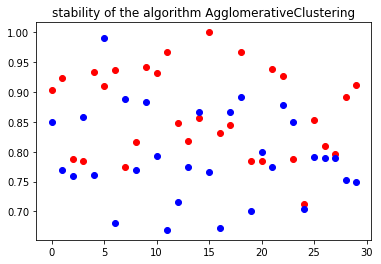

In [17]:
plt.plot(stabilitymethode2(noisy_moons_1[0],30,2),'ro')
plt.plot(stabilitymethode2(noisy_moons_3[0],30,2),'bo')
plt.title("stability of the algorithm AgglomerativeClustering")

we see here that the stability is a lower than for the spectral clustering for both datasets.
however if we change the linkage we find an hyper-stable algorithm for both datasets, wich is a better result than Spectral Clustering. (we know nothing about it's efficiency and precision, just it's stability)

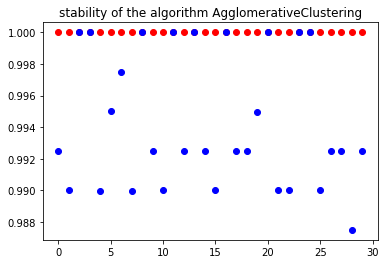

In [18]:
plt.plot(stabilitymethode2(noisy_moons_1[0],30,2,linkage="average"),'ro')
plt.plot(stabilitymethode2(noisy_moons_3[0],30,2,linkage="average"),'bo')
plt.title("stability of the algorithm AgglomerativeClustering")

### Experiment on MNIST

In [20]:
# Add your code here
from tensorflow.examples.tutorials.mnist import input_data
#we can choose between those datasets
mnist = input_data.read_data_sets("MNIST_data/").train.images[:200] 
#mnist = load_digits().data

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


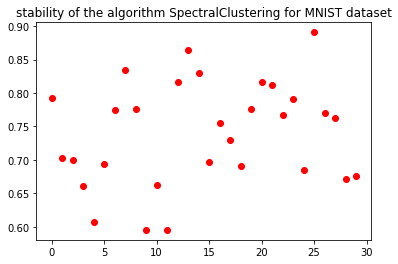

In [21]:
plt.plot(stabilitymethode(mnist,30,10),'ro')
plt.title("stability of the algorithm SpectralClustering for MNIST dataset")

The stability of the algorithm is less true here than before and we can assume that Mnist dataset is noisy.

let's see if the Agglomerative algorithm resists better to this dataset:

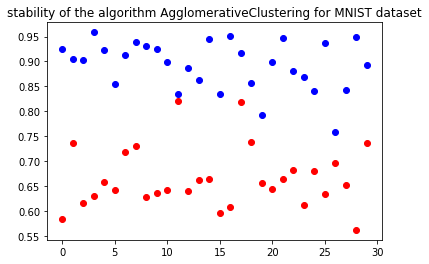

In [22]:
plt.plot(stabilitymethode2(mnist,30,10),'ro')
plt.plot(stabilitymethode2(mnist,30,10,linkage="average"),'bo')
plt.title("stability of the algorithm AgglomerativeClustering for MNIST dataset")

The Ward linkage gives lower results than the Spectral clustering for stability but the average linkage is still stable (most above 0.8 of stability)

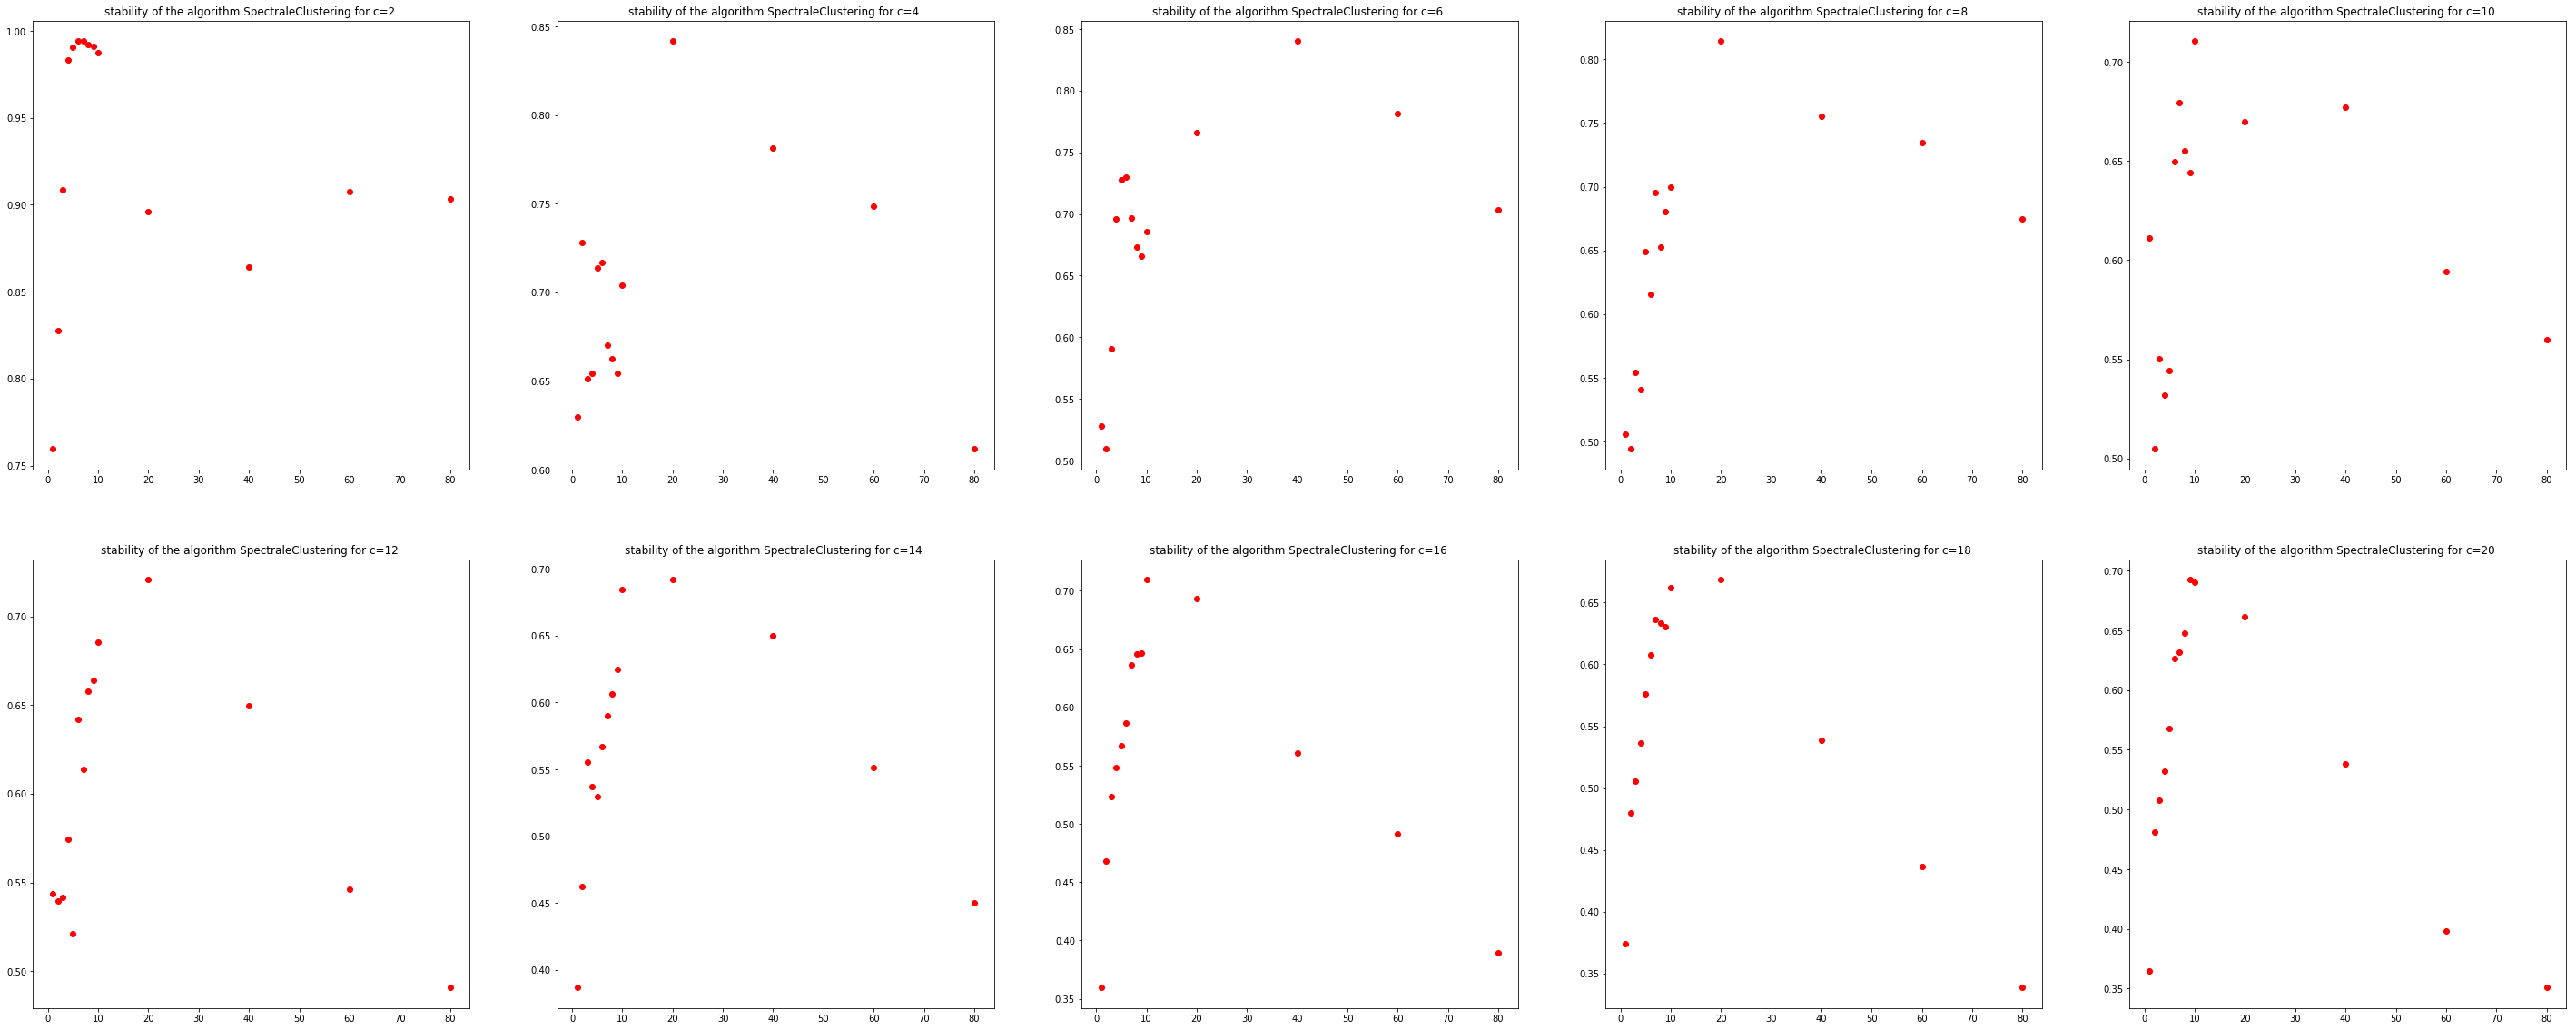

In [35]:
#let's plot the mean stability for different values of C and k with the Spectral Clustering algorithm
K = [1,2,3,4,5,6,7,8,9,10,20,40,60,80]
C = [2,4,6,8,10,12,14,16,18,20]

fig = plt.figure(figsize=(50,20))
for l,c in enumerate(C):
    ax = plt.subplot(2,5, l+1)
    mean = []
    for k in K:
        mean.append(np.mean(stabilitymethode(mnist,30,c,k=k)))
    ax.plot(K,mean,'ro')
    ax.set_title("stability of the algorithm SpectraleClustering for c=%s " %(str(c)))
plt.show()

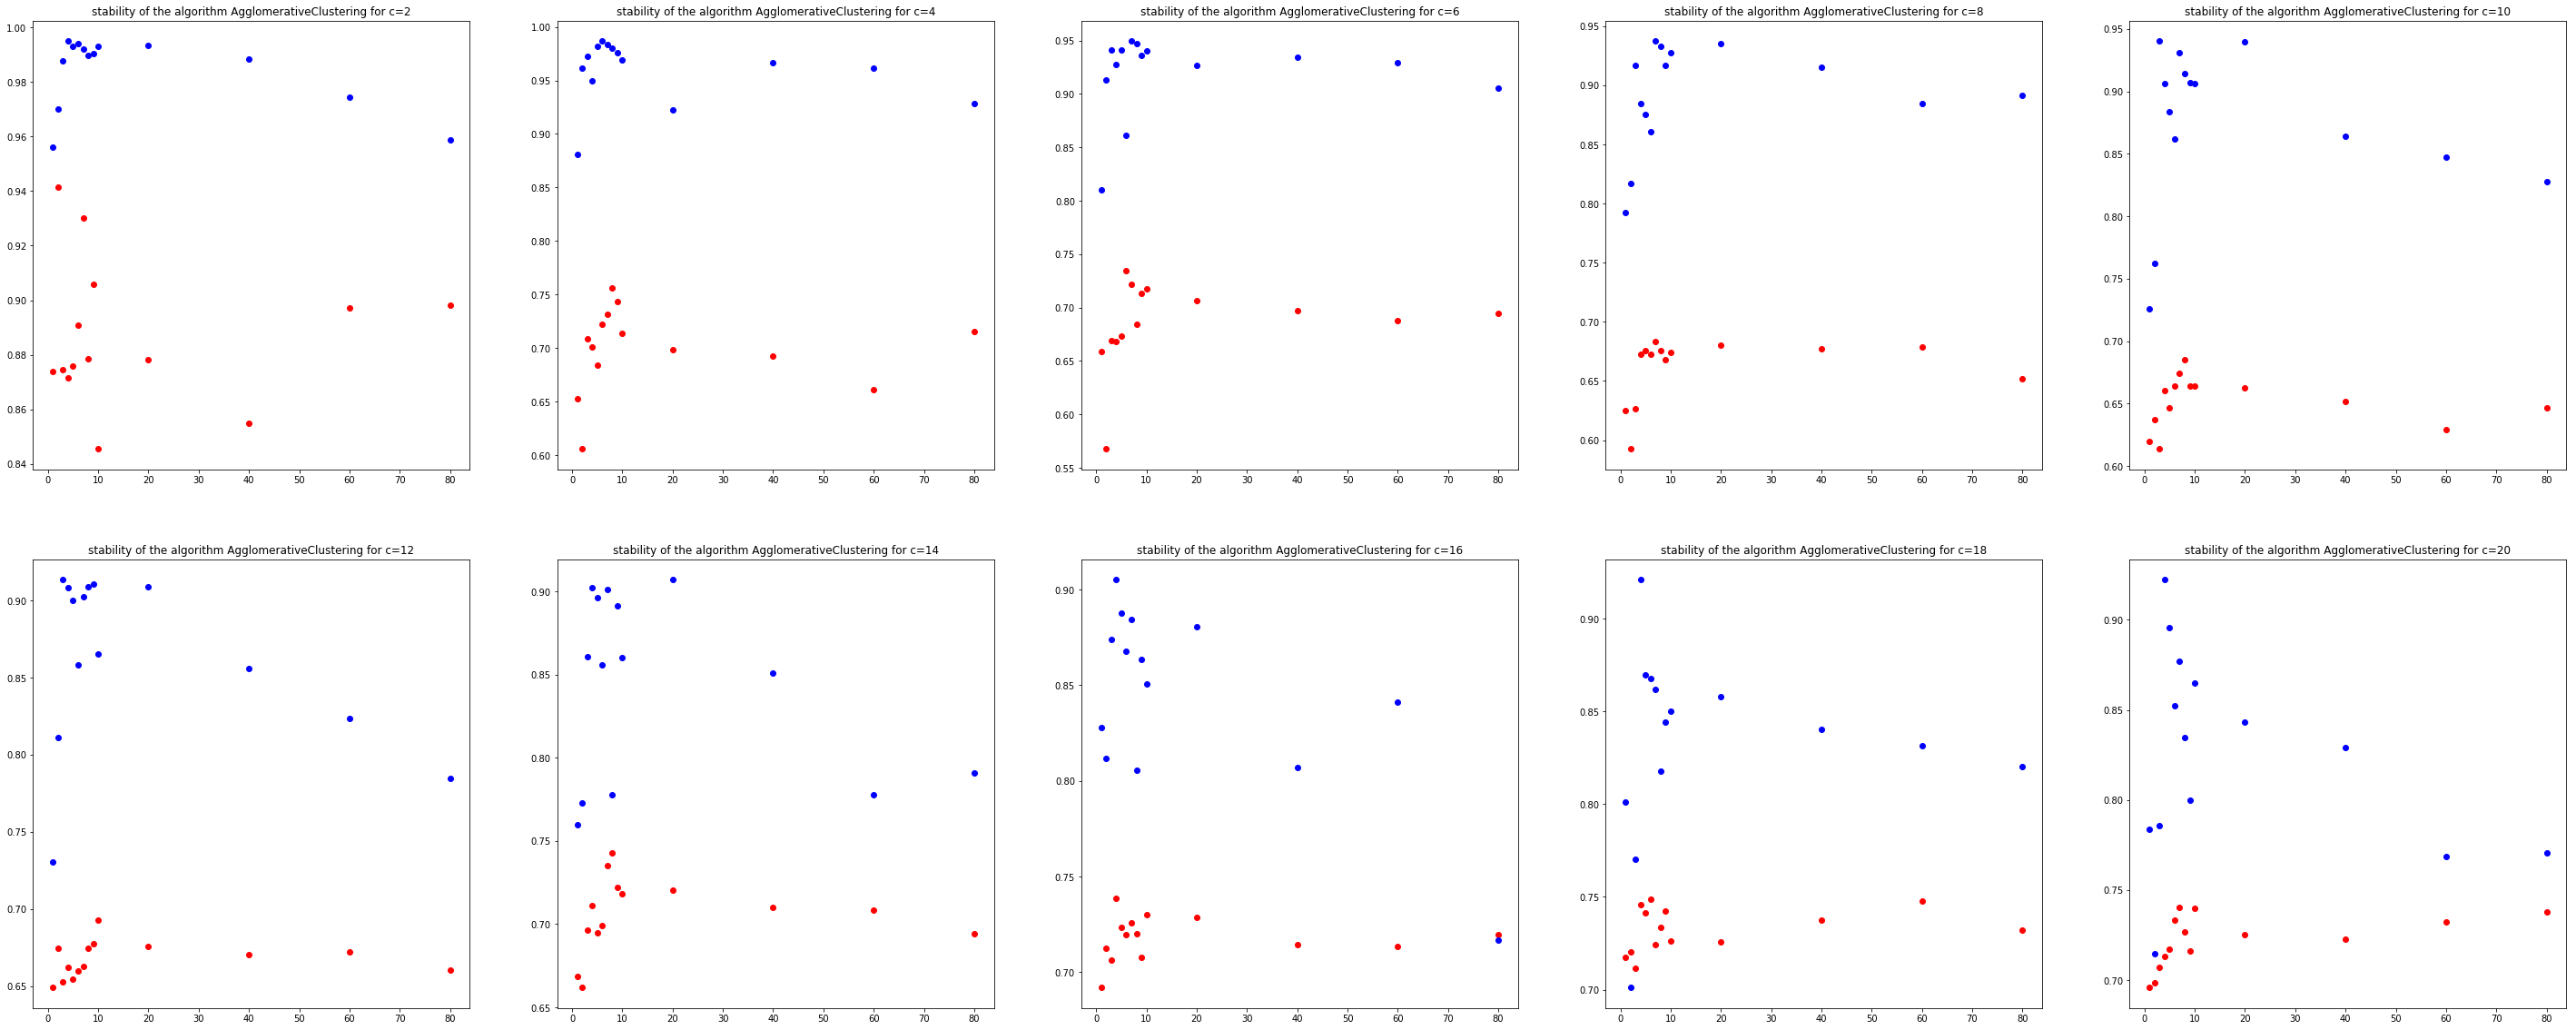

In [28]:
#let's plot the mean stability for different values of C and k with the Agglomerative Clustering algorithm
fig = plt.figure(figsize=(50,20))
for l,c in enumerate(C):
    ax = plt.subplot(2,5, l+1)
    mean_1 = []
    mean_2 = []
    for k in K:
        mean_1.append(np.mean(stabilitymethode2(mnist,30,c,k=k)))
        mean_2.append(np.mean(stabilitymethode2(mnist,30,c,k=k,linkage="average")))
    ax.plot(K,mean_1,'ro',K,mean_2,'bo')
    ax.set_title("stability of the algorithm AgglomerativeClustering for c=%s" %(str(c)))
plt.show()

for 1 we find that optimum C is equal to: 46
for 2 we find that optimum C is equal to: 73
for 3 we find that optimum C is equal to: 17
for 4 we find that optimum C is equal to: 35
for 5 we find that optimum C is equal to: 104
for 6 we find that optimum C is equal to: 42
for 7 we find that optimum C is equal to: 53
for 8 we find that optimum C is equal to: 33
for 9 we find that optimum C is equal to: 91
for 10 we find that optimum C is equal to: 114
for 11 we find that optimum C is equal to: 42
for 12 we find that optimum C is equal to: 68
for 13 we find that optimum C is equal to: 93
for 14 we find that optimum C is equal to: 122
for 15 we find that optimum C is equal to: 65
for 16 we find that optimum C is equal to: 114
for 17 we find that optimum C is equal to: 27
for 18 we find that optimum C is equal to: 27
for 19 we find that optimum C is equal to: 20
for 20 we find that optimum C is equal to: 18
for 21 we find that optimum C is equal to: 198
for 22 we find that optimum C is equal

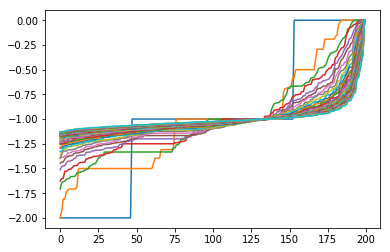

In [37]:
#we now compare with the eigengap procedure
K = [i+1 for i in range(40)]
gaps = []
for k in K:
    connectivity = kneighbors_graph(mnist, n_neighbors=k).toarray()
    row_sums = connectivity.sum(axis=1)
    connectivity = connectivity / row_sums[:, np.newaxis]
    d = np.diag([np.sum(i) for i in connectivity])
    L = connectivity-d
    #we find the eigen values:
    v = np.sort(np.linalg.eig(L)[0])
    #and we find the maximum gap
    all_gap = [abs(v[i+1]-v[i]) for i in range(len(v)-1)]
    gap = np.argmax(all_gap)
    gaps.append(gap)
    print("for %s we find that optimum C is equal to: %s" %(str(k),str(gap)))
    plt.plot(v)

As we can see the eigengap procedure is too sensitive on outliers and doesn't give us the same results at all. It also depends on the Laplcian we compute. 
on the other hand, eventhough the stability algorithm has less effective results on the real dataset, we can maximise this stability and every grapg above shows us that around k=10 for every C we reach a maximum and for C=2 and C=4 we have a stability around 0.95 allowing us to choose between a few values of C. 

## Semi-Supervised Learning

Choice of the dataset used : **Precise** which dataset you chose and why it is relevant for the semi-supervised learning Task

Advised datasets :

*Breast Cancer Wisconsin (Diagnostic) Database*

*MNIST binary even vs odd (multiple clusters inside each class)*

Feel free to use other datasets if they are relevant

In [67]:

### For all the next questions, use Cancer and Mnist classes to handle your data if you choose to use these one,
### You can also add more datasets but we advise you to handle them with this class for better readability
class semi_sup_dat:
    def __init__(self,data,p_unlabelled,name):
        # DON T CHANGE THE RANDOM STATES
        self.name = name
        if self.name == 'Mnist':
            # do an even vs odd binary classification :
            even = [0,2,4,6,8]
            Y = np.asarray([int(y in even) for y in data.target])
        else:
            Y = data.target
        X, X_test, y, y_test = train_test_split(data.data, Y, test_size=0.2, random_state=32)
        X_lab, X_unlab, y_lab, y_unlab = train_test_split(X, y, test_size=p_unlabelled, random_state=32)
        self.X_lab = X_lab
        self.X_unlab = X_unlab
        self.y_lab = y_lab
        self.y_unlab = y_unlab
        self.X_test = X_test
        self.y_test = y_test

        
class load_moons:
    def __init__(self):
        X,Y = make_moons(n_samples=500,noise=0.1)
        self.data = X
        self.target = Y


# The following lines can be called later in the code to build a dataset with varying unlabelled proportion

p_unlabelled = 0.8 # You can change this value

Cancer = semi_sup_dat(load_breast_cancer(), p_unlabelled,'Cancer')
digits = load_digits()

Mnist = semi_sup_dat(load_digits(), p_unlabelled,'Mnist')
#let's Use Mnist for the following questions
Moons = semi_sup_dat(load_moons(),p_unlabelled,'moons')
Moons_test = semi_sup_dat(load_moons(),p_unlabelled,'moons')

### Question 9-10 : Complete the code in the box below

In [68]:
#  Question 9  : Complete the function self_training
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import cdist

def self_training(dataset,batch_size,verbose=True,dist ='proba'):
    predicted = dataset.X_lab
    y = dataset.y_lab
    y_true = y
    not_predicted = dataset.X_unlab
    y_not_predicted = dataset.y_unlab
    #train the Knn using the labelded data
    neigh = KNeighborsClassifier(n_neighbors=2)
    neigh.fit(predicted,y)
    #we now predict a small dataset "close" to our already predicted one
    while(len(not_predicted)>0):
        
        #compute the "distance" and take the the argmin n time
        if len(not_predicted)<=batch_size:
            to_be_predicted = not_predicted
        else:
            if(dist == 'eucl'):
            #find the closest point in the predicted data set for each point of the not yet predicted data set
                C = predicted[np.argmin(cdist(not_predicted,predicted,'chebyshev'),1)] 
                distance = [np.linalg.norm(ci - not_predicted_i) for ci,not_predicted_i in zip(C,not_predicted)]
                idx = np.asarray(distance).argsort()[:batch_size]
                to_be_predicted = not_predicted[idx]
                t = y_not_predicted[idx]
            else:
            # find the point with the highest probabilities
                proba = neigh.predict_proba(not_predicted)
                distance = np.maximum(proba[:,0],proba[:,1]) # need an update of this line if the number of cluster changes
                idx = np.asarray(distance).argsort()[-batch_size:]
                to_be_predicted = not_predicted[idx]
                t = y_not_predicted[idx]
        
        #after finding the closest values we predict them
        y_new = neigh.predict(to_be_predicted)
        y_true = np.concatenate((y_true,t))
        #and we add this to the already predicted data set
        predicted = np.concatenate((predicted,to_be_predicted))
        
        
        y = np.concatenate((y,y_new))    
        #and we remove it from the not yet predicted data set
        if (len(not_predicted)<=batch_size): 
            not_predicted = []
            y_not_predicted = []
        else:
            not_predicted = np.delete(not_predicted,idx,axis = 0)
            y_not_predicted = np.delete(y_not_predicted,idx,axis = 0)
        
        #let's now retrain our classifier on the extended data set
        neigh = KNeighborsClassifier(n_neighbors=2)
        neigh.fit(predicted,y)
   
    
    #and we can calculate the accuracy of the prediction
    acc = [1 if yi == y_truei else 0 for yi,y_truei in zip(y,y_true)]
    if(verbose):
        print('accuracy on the train set for %s is equal to: %s' %(dataset.name,str((((np.sum(acc))-len(dataset.y_lab))/(len(acc)-len(dataset.y_lab))))))
    y_pred_test = neigh.predict(dataset.X_test)
    acc2 = [1 if yi == y_truei else 0 for yi,y_truei in zip(y_pred_test,dataset.y_test)]
    if(verbose):
        print('accuracy on the test set for %s is equal to: %s'%(dataset.name,str(np.sum(acc2)/len(acc2))))
    a = [((np.sum(acc))-len(dataset.y_lab))/(len(acc)-len(dataset.y_lab)),np.sum(acc2)/len(acc2)]
    return (predicted,y,a)


accuracy on the train set for moons is equal to: 0.990625
accuracy on the test set for moons is equal to: 1.0
accuracy on the train set for moons is equal to: 0.990625
accuracy on the test set for moons is equal to: 1.0


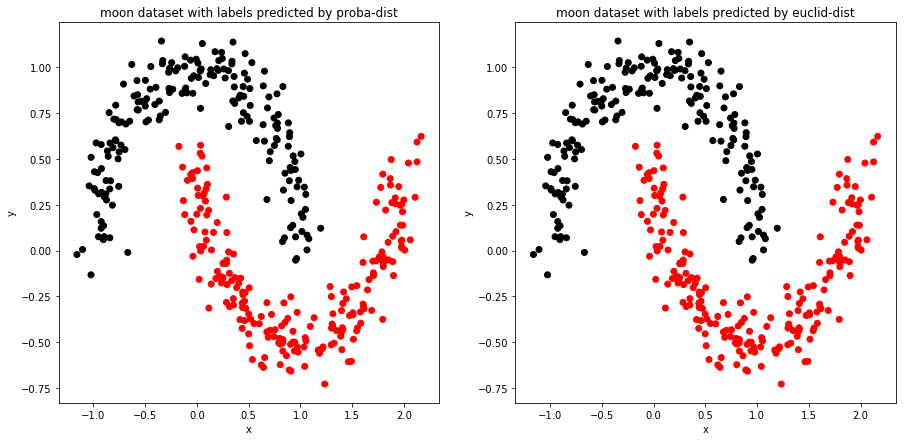

In [69]:
#try the algo on toy dataset
p = self_training(Moons,5)
e = self_training(Moons,5,dist='eucl')

colors = np.array(['black','red'])

figure = plt.figure(figsize=(15, 7))

axes = figure.add_subplot(1, 2, 1)
axes.scatter(p[0][:,0], p[0][:,1], color = colors[p[1]].tolist())
axes.set_title('moon dataset with labels predicted by proba-dist')
plt.xlabel('x')
plt.ylabel('y')

axes = figure.add_subplot(1, 2, 2)
axes.scatter(e[0][:,0], e[0][:,1], color = colors[e[1]].tolist())
axes.set_title('moon dataset with labels predicted by euclid-dist')
plt.xlabel('x')
plt.ylabel('y')

In [70]:
print('self training with probabilistic distance ')
self_training(Mnist,5)
print(' ')
self_training(Cancer,5)

print(' ')
print('self training with euclidiean distance ')
self_training(Mnist,5,dist='eucl')
print(' ')
r = self_training(Cancer,5,dist='eucl')


self training with probabilistic distance 
accuracy on the train set for Mnist is equal to: 0.988695652174
accuracy on the test set for Mnist is equal to: 0.986111111111
 
accuracy on the train set for Cancer is equal to: 0.947802197802
accuracy on the test set for Cancer is equal to: 0.885964912281
 
self training with euclidiean distance 
accuracy on the train set for Mnist is equal to: 0.952173913043
accuracy on the test set for Mnist is equal to: 0.963888888889
 
accuracy on the train set for Cancer is equal to: 0.953296703297
accuracy on the test set for Cancer is equal to: 0.894736842105


### Question 11-12 : Complete the code in the box below

###### Closed form expression :

let's remind first the problem we are looking to solve:
$$ \min_{f\in \mathcal{H}_k} \frac{1}{l} \sum_{i=1}^{l}(y_i - f(x_i))^2 + \lambda \|f\|_{\mathcal{H}k}^{2} + \frac{\lambda_u}{(u+l)^2} f^T L f $$

the representation theroem gives us the decomposotition on the kernel coordinates:
$$ \qquad \exists (b_n)_{n \in \mathbb{n}} \quad f = \sum_{i=1}^{+\infty}\alpha_i k(\cdot,b_i) $$

we had:  
$$\displaystyle \min_{f\in \mathcal{H}_k} \frac{1}{l} \sum_{i=1}^{l}(y_i - f(x_i))^2 + \lambda \|f\|_{\mathcal{H}k}^{2} + \frac{\lambda_u}{(u+l)^2} f^T L f \\ $$  
wich now can be transformed into:
$$
\alpha^{\star} = \displaystyle \mathit{argmin}_{\alpha\in\mathbb{R}^n} \frac{1}{l}||Y - JK\alpha||^2 + \lambda\alpha^TK\alpha + \frac{\lambda_u}{(u + l)^{2}} \alpha^TKLK\alpha \\ $$

with:  
l the number of labeled training data  
u the number of unlabeld training data  
L the laplacian matrix  
K is the (l+u)x(l+u) Gram matrix over labeled and unlabeled points  
Y is an (l + u) dimensional label vector made of the label of the known data and completed by zeros  
J is an (l + u) × (l + u) diagonal matrix with the first l diagonal entries as 1 and the rest 0.


we now derivate to find the minimum argument of this function of $\alpha$


$$
\frac{1}{l}(Y - JK\alpha)^{T}(-JK) + (\lambda K + \frac{\lambda_u l}{(u+l)^2} KLK)\alpha = 0 \\
$$

and thus:  
$$
\alpha^{\star} = (J K+ \lambda l Id + \frac{\lambda_u l}{(u+l)^2} L K)^{-1} Y
$$

we now use this closed form expression in the following

In [71]:
from sklearn.metrics.pairwise import rbf_kernel # Or reimplement it yourself if your prefer
from scipy.linalg import block_diag
from matplotlib.colors import ListedColormap
#here we using the closed form expression to find the result
def LapRLS(dataset,lamb,lamb_u,k=10,ax = 0,param_rbf=400,plot = True,verbose = True):
    # we change the target to be in {-1,1}
    y_lab = [(x-0.5)*2 for x in dataset.y_lab]
    #using the results of the article we build the matrix we need to solve the minimisation problem
    X = np.concatenate((dataset.X_lab,dataset.X_unlab))
    l = len(dataset.X_lab)
    u = len(dataset.X_unlab)
    n = l+u
    Y = np.concatenate((y_lab,[0]*u))
    # building K:
    K = rbf_kernel(X,X,1/(param_rbf))
    # building W
    A = kneighbors_graph(X,k)
    W = A*K
    # building D
    d = [np.sum(W[i]) for i in range(n)]
    D = np.diag(d)
    #building L
    L = D-W
    #building J
    J = np.diag(np.concatenate(([1]*l,[0]*u)))
    # buiding the last matrix 
    R = J.dot(K) + lamb*l*np.identity(n)+((lamb_u/n**2))*l*L.dot(K)
    alpha = np.linalg.solve(R,Y)
    if(verbose):
        print("norme de alpha*: "+str(np.linalg.norm(alpha)))
    ################## plot #######################################
    if(plot): #only for moons
        
        h = .02
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
        cm = plt.cm.RdBu
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])
        ax.scatter(dataset.X_lab[:, 0], dataset.X_lab[:, 1], c=dataset.y_lab, cmap=cm_bright,edgecolors='k')
        ax.scatter(dataset.X_test[:, 0],dataset.X_test[:, 1], c=dataset.y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        res = []
        for x in np.c_[xx.ravel(), yy.ravel()] :
            c= []
            for alpha_i,x_i in zip(alpha,X):
                c.append(alpha_i*np.exp(-(np.linalg.norm(x-x_i)**2)/(param_rbf)))
            res.append(np.sum(c))
        res = np.asarray([(x+1)/2 for x in res])
        res = np.asarray(res).reshape([len(xx),len(xx[1])])
        ax.contourf(xx, yy, res, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(dataset.X_lab[:, 0], dataset.X_lab[:, 1], c=dataset.y_lab, cmap=cm_bright,
                   edgecolors='k')
        # and testing points
        ax.scatter(dataset.X_test[:, 0], dataset.X_test[:, 1], c=dataset.y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title("lambda= %s , lambda_u= %s" %(str(lamb),str(lamb_u)))
    ################################### we now use alpha #################################
    res = []
    for x in dataset.X_test:
        c= []
        for alpha_i,x_i in zip(alpha,X):
            c.append(alpha_i*np.exp(-(np.linalg.norm(x-x_i)**2)/(param_rbf)))
        res.append(np.sum(c))
   
    
    res = [1 if x>0 else 0 for x in res]
    if(verbose):
        print(np.sum(res))
    acc = [1 if x==y else 0 for x,y  in zip(res,dataset.y_test)]
    if(verbose):
        print('accuracy for %s is equal to: %s' %(dataset.name,str(np.sum(acc)/len(acc))))
    return(alpha,res,np.sum(acc)/len(acc))

lambda= 0.01 , lambda_u= 1000
lambda= 0.01 , lambda_u= 100
lambda= 0.01 , lambda_u= 10
lambda= 0.01 , lambda_u= 1
lambda= 0.01 , lambda_u= 0.1
lambda= 0.01 , lambda_u= 0.01
lambda= 0.01 , lambda_u= 0.001


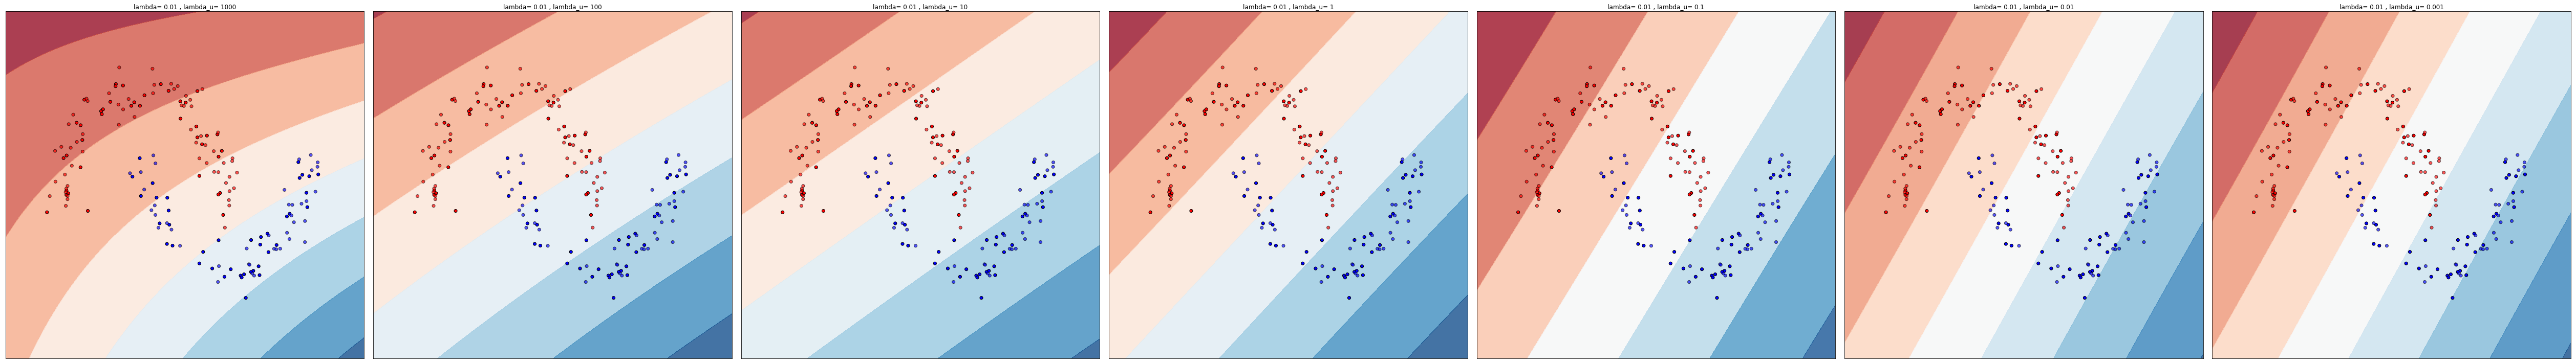

lambda= 0.001 , lambda_u= 1000
lambda= 0.001 , lambda_u= 100
lambda= 0.001 , lambda_u= 10
lambda= 0.001 , lambda_u= 1
lambda= 0.001 , lambda_u= 0.1
lambda= 0.001 , lambda_u= 0.01
lambda= 0.001 , lambda_u= 0.001


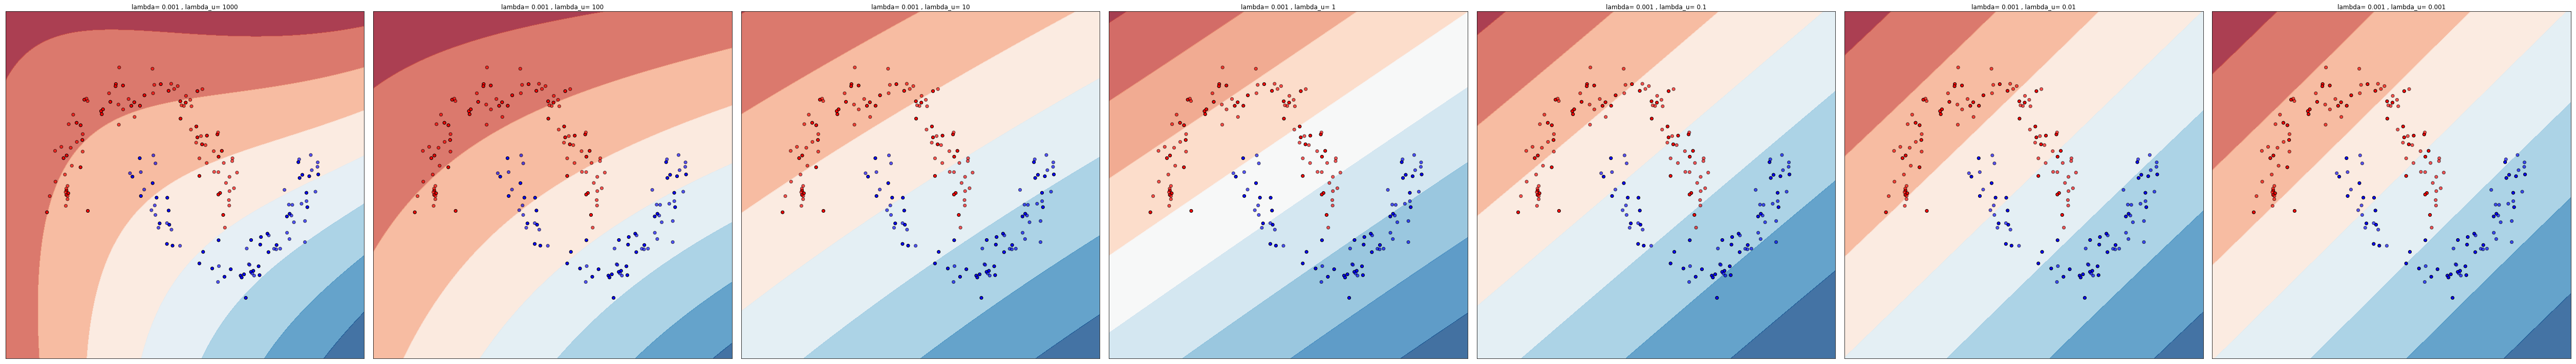

lambda= 0.0001 , lambda_u= 1000
lambda= 0.0001 , lambda_u= 100
lambda= 0.0001 , lambda_u= 10
lambda= 0.0001 , lambda_u= 1
lambda= 0.0001 , lambda_u= 0.1
lambda= 0.0001 , lambda_u= 0.01
lambda= 0.0001 , lambda_u= 0.001


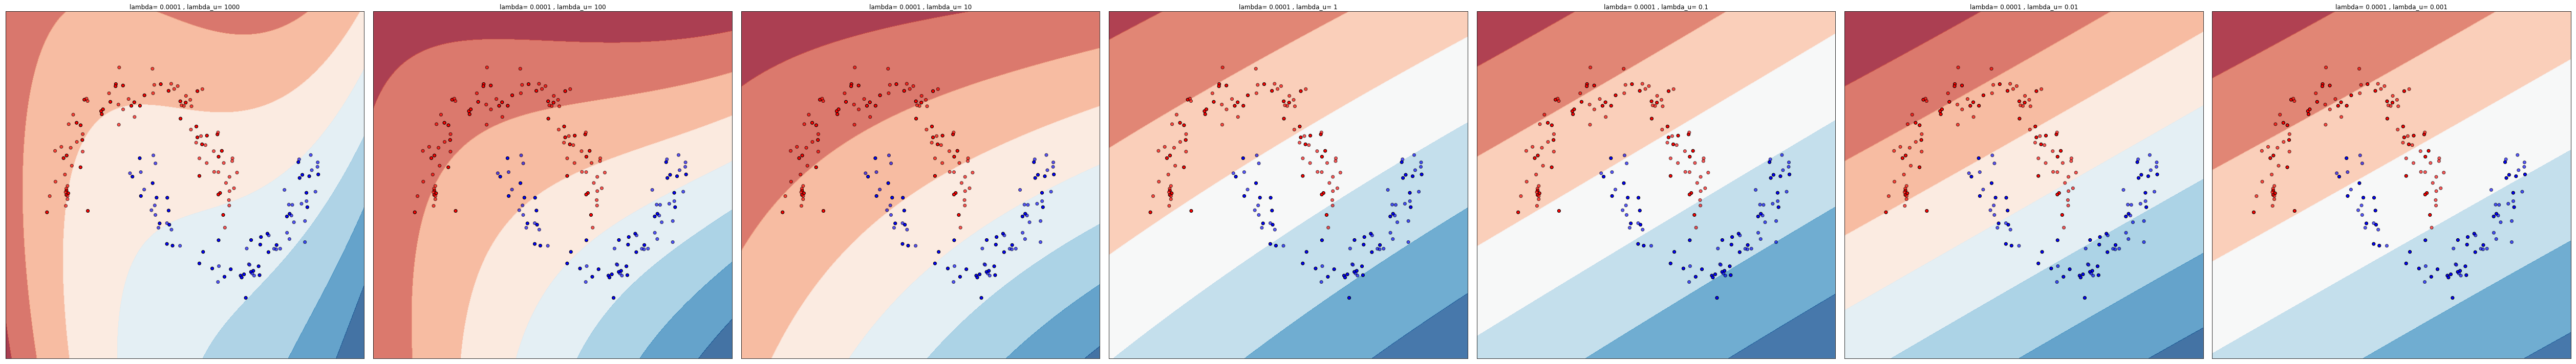

lambda= 1e-05 , lambda_u= 1000
lambda= 1e-05 , lambda_u= 100
lambda= 1e-05 , lambda_u= 10
lambda= 1e-05 , lambda_u= 1
lambda= 1e-05 , lambda_u= 0.1
lambda= 1e-05 , lambda_u= 0.01
lambda= 1e-05 , lambda_u= 0.001


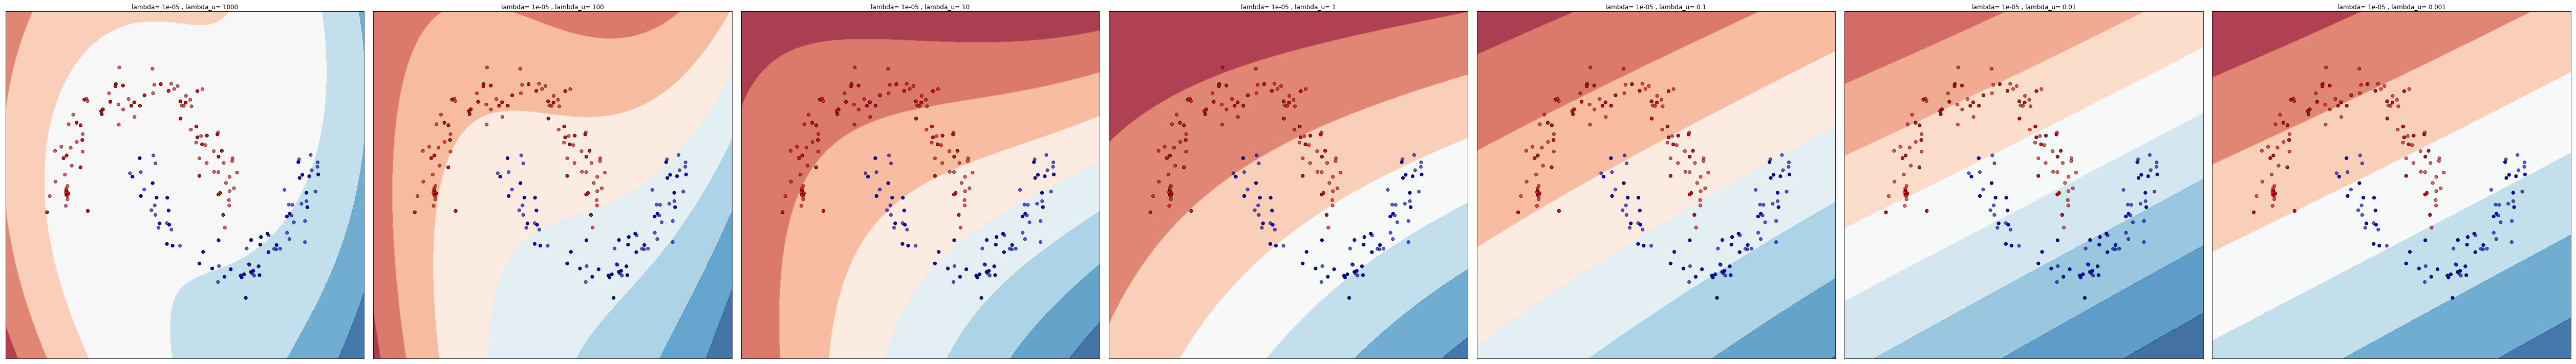

lambda= 1e-06 , lambda_u= 1000
lambda= 1e-06 , lambda_u= 100
lambda= 1e-06 , lambda_u= 10
lambda= 1e-06 , lambda_u= 1
lambda= 1e-06 , lambda_u= 0.1
lambda= 1e-06 , lambda_u= 0.01
lambda= 1e-06 , lambda_u= 0.001


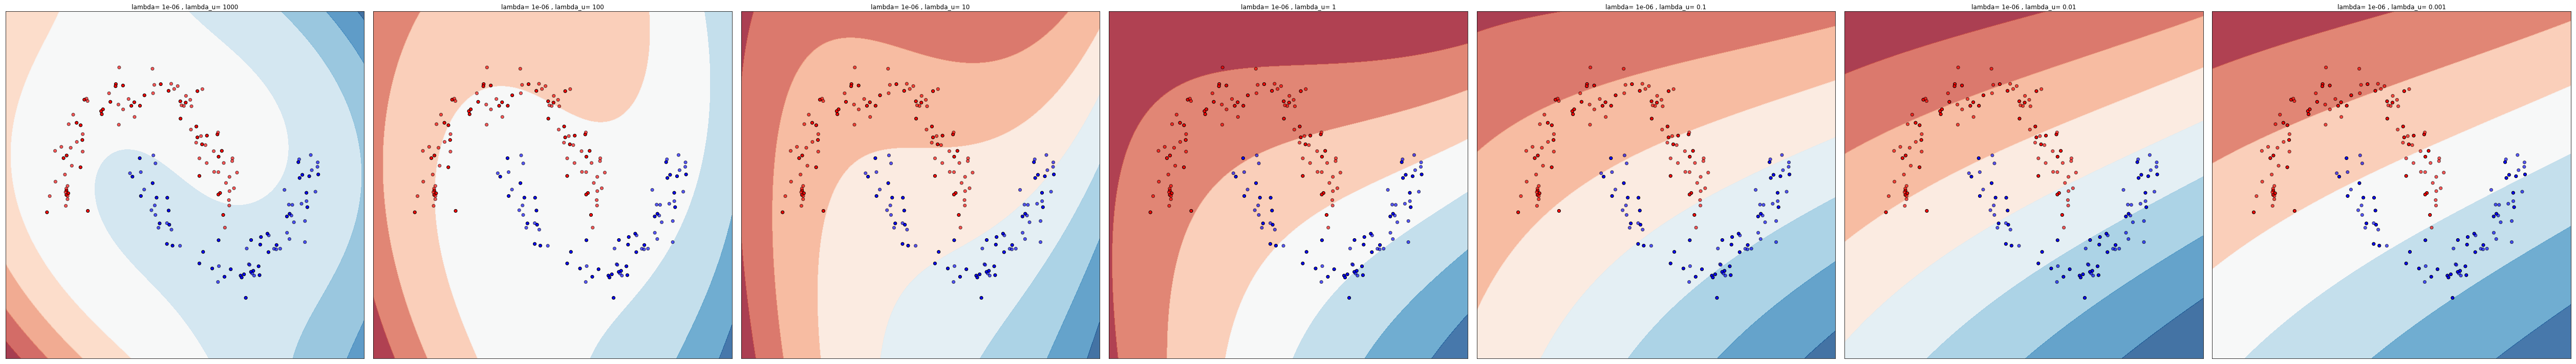

lambda= 1e-07 , lambda_u= 1000
lambda= 1e-07 , lambda_u= 100
lambda= 1e-07 , lambda_u= 10
lambda= 1e-07 , lambda_u= 1
lambda= 1e-07 , lambda_u= 0.1
lambda= 1e-07 , lambda_u= 0.01
lambda= 1e-07 , lambda_u= 0.001


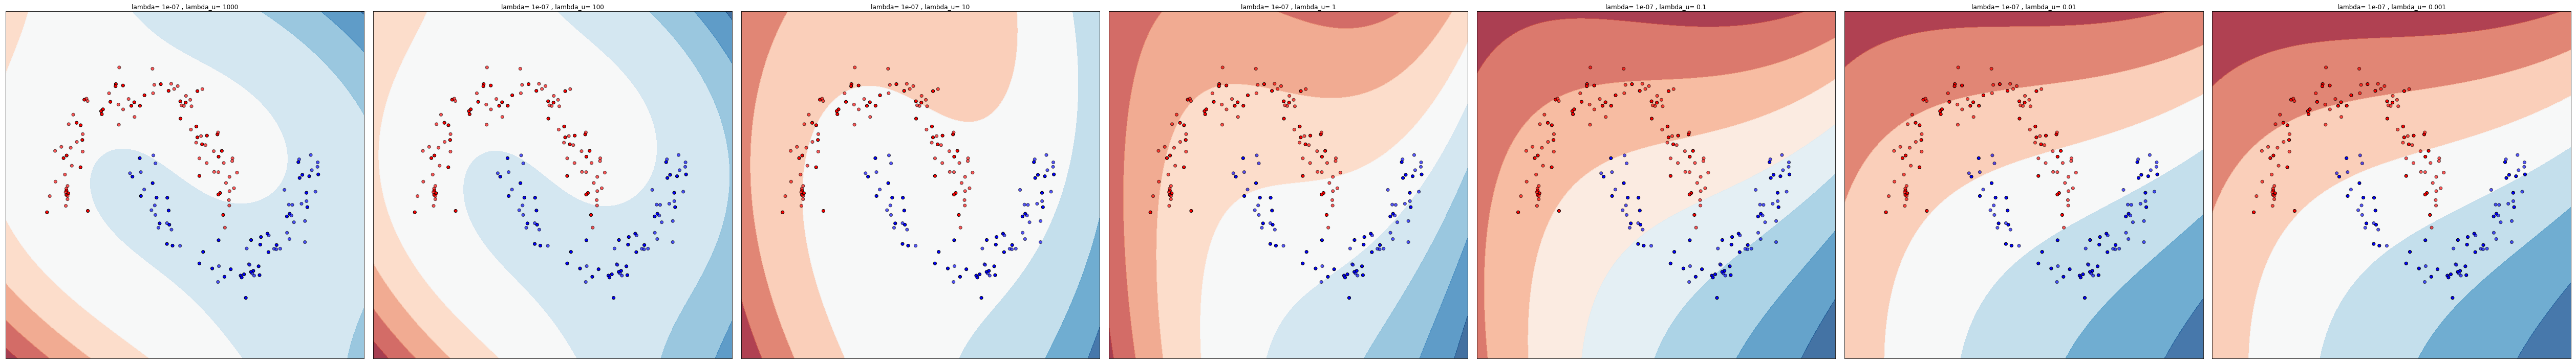

lambda= 1e-08 , lambda_u= 1000
lambda= 1e-08 , lambda_u= 100
lambda= 1e-08 , lambda_u= 10
lambda= 1e-08 , lambda_u= 1
lambda= 1e-08 , lambda_u= 0.1
lambda= 1e-08 , lambda_u= 0.01
lambda= 1e-08 , lambda_u= 0.001


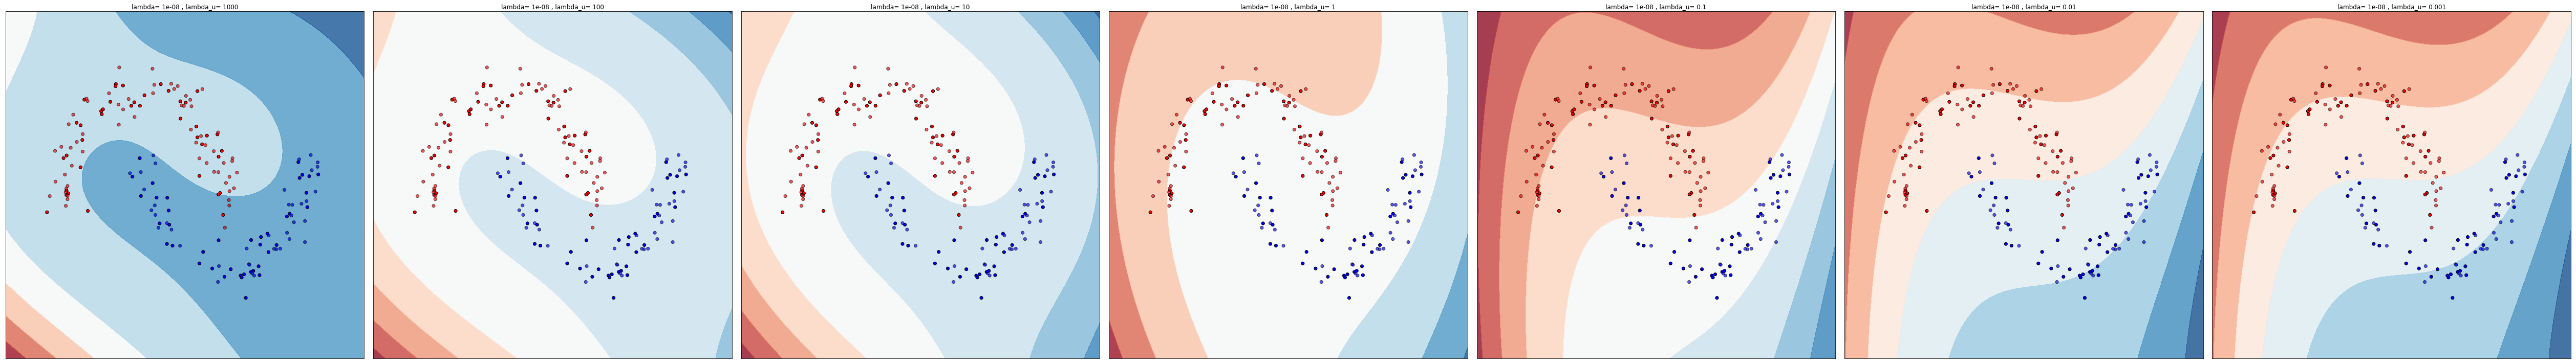

lambda= 1e-09 , lambda_u= 1000
lambda= 1e-09 , lambda_u= 100
lambda= 1e-09 , lambda_u= 10
lambda= 1e-09 , lambda_u= 1
lambda= 1e-09 , lambda_u= 0.1
lambda= 1e-09 , lambda_u= 0.01
lambda= 1e-09 , lambda_u= 0.001


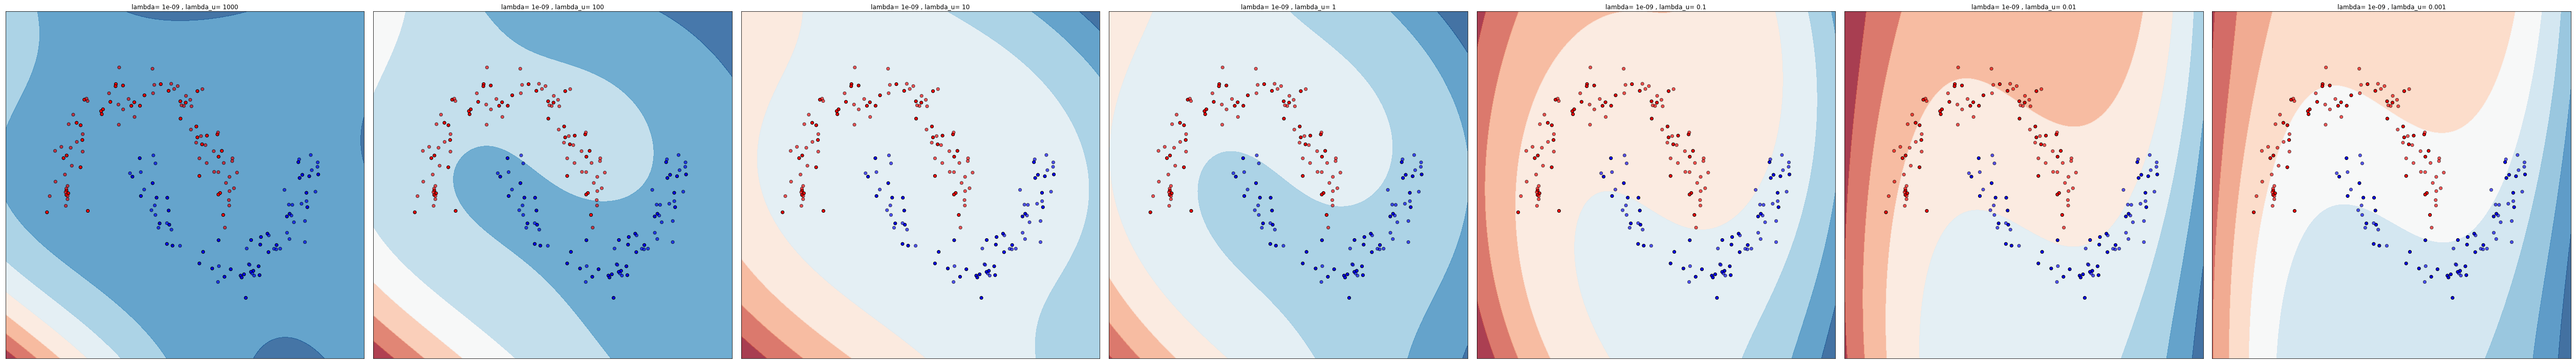

lambda= 1e-10 , lambda_u= 1000
lambda= 1e-10 , lambda_u= 100
lambda= 1e-10 , lambda_u= 10
lambda= 1e-10 , lambda_u= 1
lambda= 1e-10 , lambda_u= 0.1
lambda= 1e-10 , lambda_u= 0.01
lambda= 1e-10 , lambda_u= 0.001


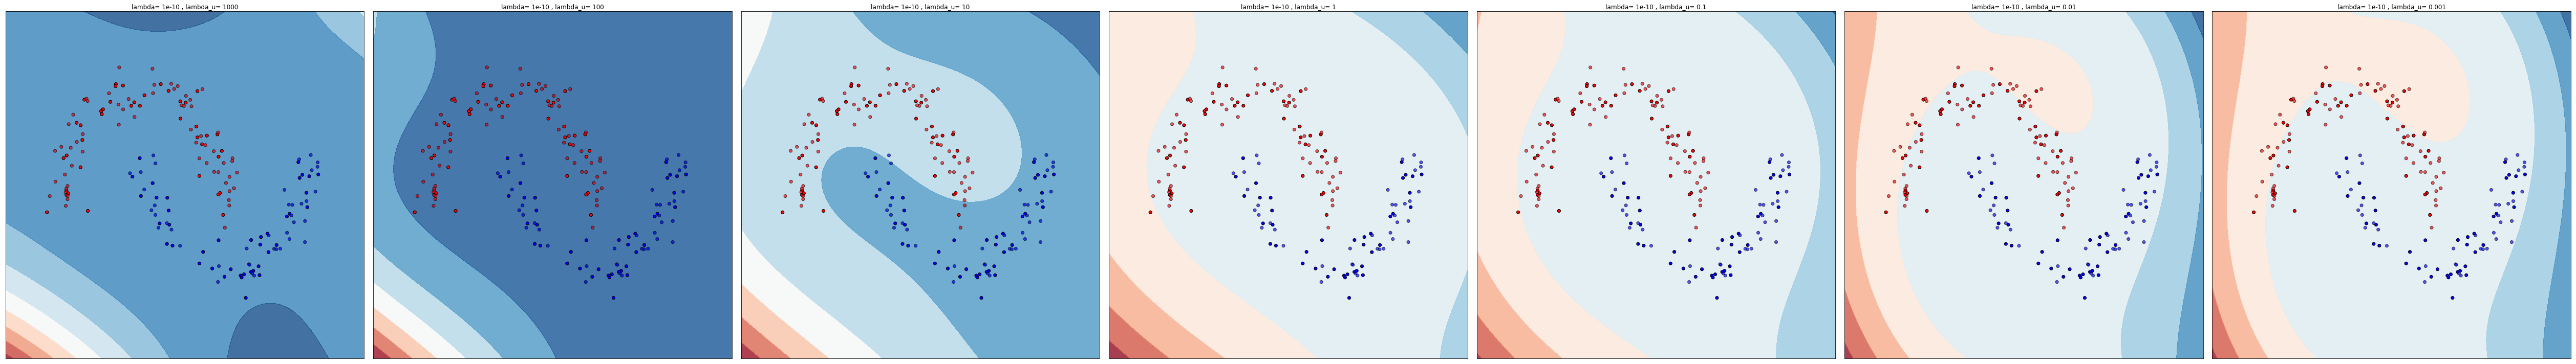

In [72]:
### we want lambda_u >> lambda ie j<<i and both ->0

# we fix lambda and play for lambda_u here (each serie of graph has a different value of lambda do show it's effect too)
# (it took me 20-30 min to run it on my computer and shouldn't be relaunch to prevent a too long waiting time)
I = [2,3,4,5,6,7,8,9,10]
J = [-3,-2,-1,0,1,2,3]
ct = 1
for i in I:
    ct = 1
    figure = plt.figure(figsize=(70,10))
    for j in J:
        ax = plt.subplot(1,len(J),ct)
        print("lambda= %s , lambda_u= %s" %(str(10**-i),str(10**-j)))
        LapRLS(Moons,10**-i,10**-j,ax=ax,verbose = False)
        ct+=1
    plt.tight_layout()
    plt.show()            

from the plot above we see that when lambda is fixed, lambda_u control the smoothness of the solution: higher it is more "polynomial"(=smooth) the solution is, lower it is more straigth the solution is (the seperation is a straight line). both extreme give poor results as shawn on the plot above.

norme de alpha*: 64192495.8935
40
accuracy for moons is equal to: 0.96


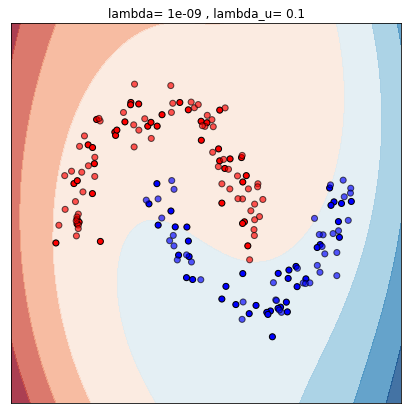

In [76]:
figure = plt.figure(figsize=(7,7))
ax = plt.subplot(1,1,1)
r=LapRLS(Moons,10**-9,0.1,ax=ax)

lambda= 0.01 , lambda_u= 1000
norme de alpha*: 5.19477028287
80
accuracy for Cancer is equal to: 0.859649122807
norme de alpha*: 1.00085236915
349
accuracy for Mnist is equal to: 0.480555555556
lambda= 0.01 , lambda_u= 100
norme de alpha*: 4.00978966036
79
accuracy for Cancer is equal to: 0.850877192982
norme de alpha*: 2.70641058315
162
accuracy for Mnist is equal to: 0.988888888889
lambda= 0.01 , lambda_u= 10
norme de alpha*: 4.03019405057
76
accuracy for Cancer is equal to: 0.877192982456
norme de alpha*: 3.12358004593
161
accuracy for Mnist is equal to: 0.986111111111
lambda= 0.01 , lambda_u= 1
norme de alpha*: 4.14814635305
76
accuracy for Cancer is equal to: 0.877192982456
norme de alpha*: 3.06423719174
162
accuracy for Mnist is equal to: 0.988888888889
lambda= 0.01 , lambda_u= 0.1
norme de alpha*: 4.16745086673
75
accuracy for Cancer is equal to: 0.885964912281
norme de alpha*: 3.05465656175
162
accuracy for Mnist is equal to: 0.988888888889
lambda= 0.01 , lambda_u= 0.01
norme d

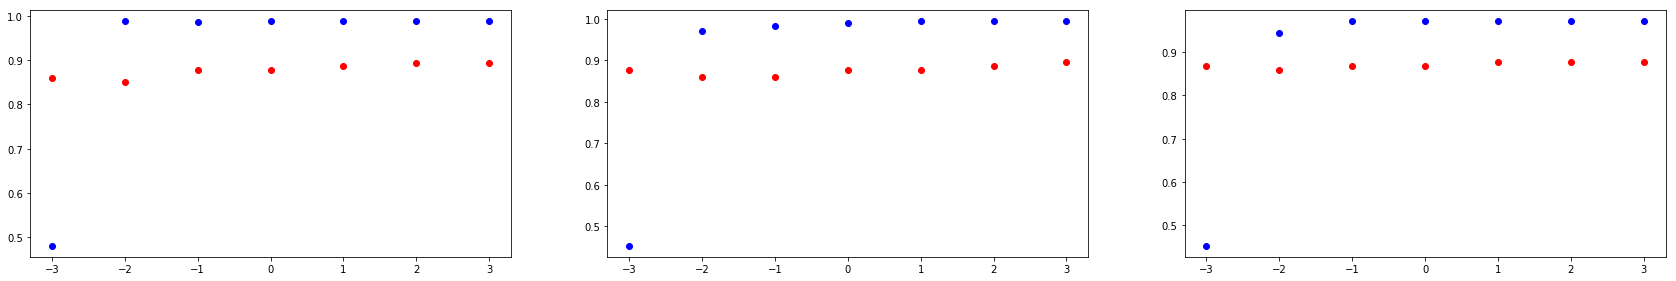

In [77]:
I = [2,3,4,5]
J = [-3,-2,-1,0,1,2,3]
ct = 1
figure = plt.figure(figsize=(50,10))
for i in I:
    acc_c = []
    acc_m = []
    ax = plt.subplot(2,5,ct)
    for j in J:
        print("lambda= %s , lambda_u= %s" %(str(10**-i),str(10**-j)))
        acc_c.append(LapRLS(Cancer,10**-i,10**-j,plot = False)[2])
        acc_m.append(LapRLS(Mnist,10**-i,10**-j,plot = False)[2])
    ct+=1
    plt.plot(J,acc_c,'ro',J,acc_m,'bo')
plt.show()
    

### Question 13 : Complete the code in the box below

the closed form expression has two main issues:  
- first the resolution of the system (equal to inverting the matrix) takes a lot of time and won't be viable for realy large datasets.  
- Second it also use a lot of memory to solve it and again it won't be viable for very large datasets.

### Question 14 : Complete the code in the box below

##### Add your answer to the question here :

We recall that an iteration of SGD (Stochastic Gradient Descent) writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

As such, for this question we will need to compute the gradient for each coordinates; by derivating 7we find:
$$ \nabla f_i(\alpha) = 2 \frac{l+u}{l}(JK)_i[(JK_i)^T \alpha - Y_i] + \lambda K \alpha + \frac{\lambda_u}{(u+l)^2}KLK\alpha$$





In [97]:
def sgd(x_init, grad_i,l,Y,K,L,J,lamb,lamb_u, n_iter=300, step=1):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    n = len(x)
    iis = np.random.randint(0, n, n * n_iter)
    for idx in range(n_iter):
        i = iis[idx]
       
        x -= step / ((idx + 1)**.5) * grad_i(i,x,l,Y,K,L,J,lamb,lamb_u)        
    return x

def grad_i(i,alpha,l,Y,K,L,J,lamb,lamb_u):
    ################# WRONG GRADIENT ==> TO BE CHANGED ###################
    n = len(alpha) 
    grad = (2*(n)/l)*(np.dot(J,K)[i])*(np.dot(np.dot(J,K[i]),alpha) - Y[i]) + lamb*np.dot(K,alpha)+(lamb_u/n**2)*np.dot(np.dot(K,L),np.dot(K,alpha))
    return grad



def LapRLS_sto(dataset,lamb,lamb_u,k=10,param_rbf=400,verbose=True):
    #using the results of the article we build the matrix we need to solve the minimisation problem
    X = np.concatenate((dataset.X_lab,dataset.X_unlab))
    l = len(dataset.X_lab)
    u = len(dataset.X_unlab)
    n = l+u
    Y = np.concatenate((dataset.y_lab,[0]*u))
    # building K:
    K = rbf_kernel(X,X,1/(param_rbf))
    # building W
    A = kneighbors_graph(X,k)
    W = A*K
    # building D
    d = [np.sum(W[i]) for i in range(n)]
    D = np.diag(d)
    #building L
    L = D-W
    #building J
    J = np.diag(np.concatenate(([1]*l,[0]*u)))
    
    #we now use the stochastic gradient methode to solve the problem
    x_init = [0]*n
    alpha = sgd(x_init,grad_i,l,Y,K,L,J,lamb,lamb_u)
    
    ################################### using alpha #################################
    res = []
    for x in dataset.X_test:
        c= []
        for alpha_i,x_i in zip(alpha,X):
            c.append(alpha_i*np.exp(-(np.linalg.norm(x-x_i)**2)/(param_rbf)))
        res.append(np.sum(c))
    if(verbose):
        print("norme de alpha*: "+str(np.linalg.norm(alpha)))
    res = [1 if x>0.5 else 0 for x in res]
    if(verbose):
        print(np.sum(res))
    acc = [1 if x==y else 0 for x,y  in zip(res,dataset.y_test)]
    if(verbose):
        print('accuracy for %s is equal to: %s' %(dataset.name,str(np.sum(acc)/len(acc))))
    return(alpha,np.sum(acc)/len(acc))

lambda= 1000 , lambda_u= 100000
lambda= 1000 , lambda_u= 10000
lambda= 1000 , lambda_u= 1000
lambda= 1000 , lambda_u= 100
lambda= 1000 , lambda_u= 10
lambda= 1000 , lambda_u= 1
lambda= 1000 , lambda_u= 0.1
lambda= 1000 , lambda_u= 0.01
lambda= 1000 , lambda_u= 0.001
lambda= 1000 , lambda_u= 0.0001
lambda= 1000 , lambda_u= 1e-05
lambda= 100 , lambda_u= 100000
lambda= 100 , lambda_u= 10000
lambda= 100 , lambda_u= 1000
lambda= 100 , lambda_u= 100
lambda= 100 , lambda_u= 10
lambda= 100 , lambda_u= 1
lambda= 100 , lambda_u= 0.1
lambda= 100 , lambda_u= 0.01
lambda= 100 , lambda_u= 0.001
lambda= 100 , lambda_u= 0.0001
lambda= 100 , lambda_u= 1e-05
lambda= 10 , lambda_u= 100000
lambda= 10 , lambda_u= 10000
lambda= 10 , lambda_u= 1000
lambda= 10 , lambda_u= 100
lambda= 10 , lambda_u= 10
lambda= 10 , lambda_u= 1
lambda= 10 , lambda_u= 0.1
lambda= 10 , lambda_u= 0.01
lambda= 10 , lambda_u= 0.001
lambda= 10 , lambda_u= 0.0001
lambda= 10 , lambda_u= 1e-05
lambda= 1 , lambda_u= 100000
lambda= 1 , la

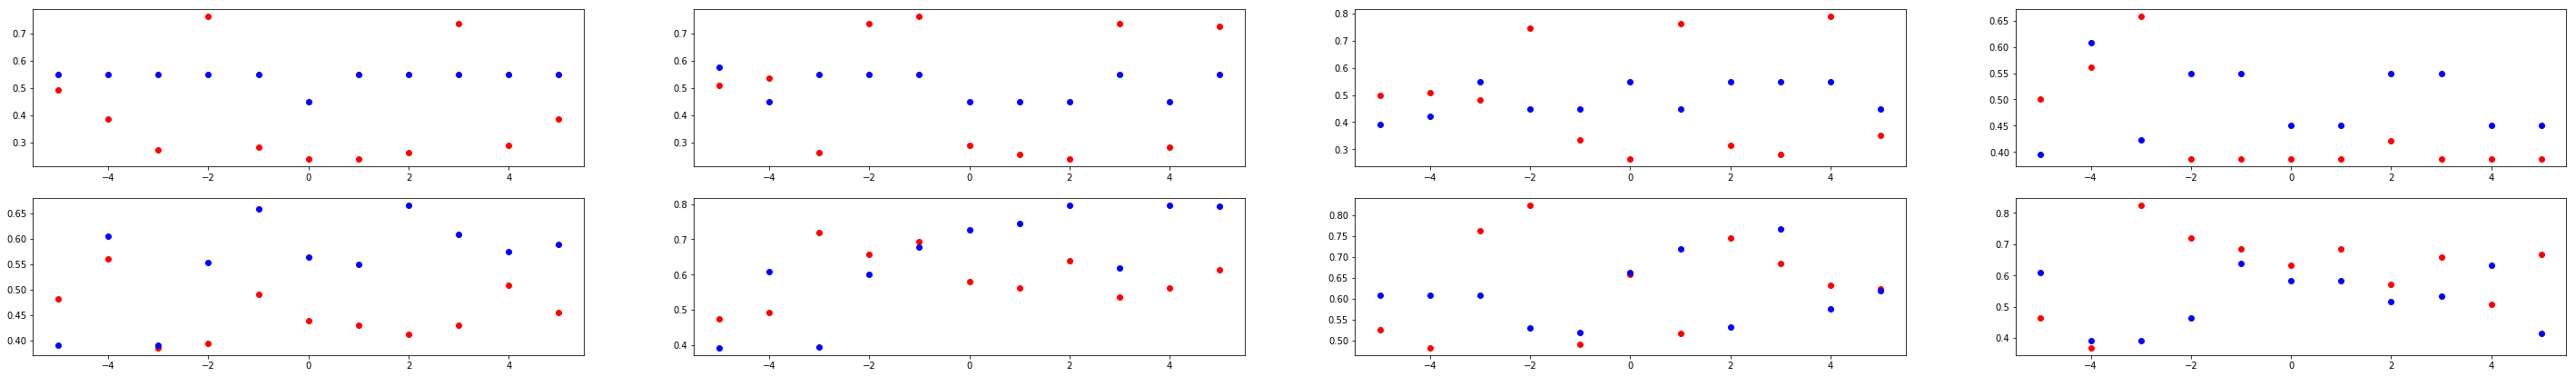

In [79]:
I = [-3,-2,-1,0,1,2,3,4]
J = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
ct = 1
figure = plt.figure(figsize=(50,20))
for i in I:
    acc_c = []
    acc_m = []
    ax = plt.subplot(2,4,ct)
    for j in J:
        print("lambda= %s , lambda_u= %s" %(str(10**-i),str(10**-j)))
        acc_c.append(LapRLS_sto(Cancer,10**-i,10**-j,verbose= False)[1])
        acc_m.append(LapRLS_sto(Mnist,10**-i,10**-j,verbose=False)[1])
    plt.plot(J,acc_c,'ro',J,acc_m,'bo')
    ct+=1
plt.show()

### Question 15 : Complete the code in the box below

In [80]:
from cvxopt import matrix
from cvxopt.blas import dot
from cvxopt.solvers import qp
from cvxopt import solvers

In [85]:
def LapSVM(dataset,lamb,lamb_u,k=10,verbose=True):
    param_rbf=4*len(dataset.X_lab[1])
    # as for LapRLS we first compute the matrix we need to solve the problem
    # we change the target to be in {-1,1}
    y_lab = [(x-0.5)*2.0 for x in dataset.y_lab]
    #using the results of the article we build the matrix we need to solve the minimisation problem
    X = np.concatenate((dataset.X_lab,dataset.X_unlab))
    l = len(dataset.X_lab)
    u = len(dataset.X_unlab)
    n = l+u
    Y = np.diag(y_lab) #Changed
    # building K:
    K = rbf_kernel(X,X,1/(param_rbf))
    # building W
    A = kneighbors_graph(X,k)
    W = A*K
    # building D
    d = [np.sum(W[i]) for i in range(n)]
    D = np.diag(d)
    #building L
    L = D-W
    #building J
    J = np.concatenate((np.diag([1]*l),np.zeros((u,l)))).T #Changed
    #print(len(J),len(J[1]))
    #print(l,u,n)
    #building Q 
    Q1 = np.dot(Y,np.dot(J,K))
    #print(len(Q1),len(Q1[1]))
    Q2 = np.dot(J.T,Y)
    #print(len(Q2),len(Q2[1]))
    R = 2*lamb*np.identity(n) + 2*(lamb_u/(n**2))*np.dot(L,K)
    Q3 = np.linalg.inv(R)
    #print(len(Q3),len(Q3[1]))
    Q = np.dot(Q1,np.dot(Q3,Q2))
    ############ to correct #############
    #we now solve the problem in b using a qp solver
    NUM = dataset.X_lab.shape[0]
    DIM = dataset.X_lab.shape[1]
    Q = Q.T
    P = matrix(Q)
    q = matrix(-np.ones((NUM, 1)))
    G = matrix(-np.eye(NUM))
    h = matrix(np.zeros(NUM))
    A = matrix(np.asarray(y_lab).reshape(1, -1))
    b = matrix(np.zeros(1))
    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b)
    b = np.array(sol['x'])
    ########################## We now find alpha* ################
    alpha = np.linalg.solve(R,np.dot(Q2,b))
    alpha_bis = np.dot(Q3,np.dot(Q2,b))
    if(verbose):
        print(np.linalg.norm(alpha-alpha_bis))
    ################################### we now use alpha #################################
    res = []
    for x in dataset.X_test:
        c= []
        for alpha_i,x_i in zip(alpha,X):
            c.append(alpha_i*np.exp(-(np.linalg.norm(x-x_i)**2)/(param_rbf)))
        res.append(np.sum(c))
   
    
    res = [1 if x>0 else 0 for x in res]
    if(verbose):
        print(np.sum(res))
    acc = [1 if x==y else 0 for x,y  in zip(res,dataset.y_test)]
    if(verbose):
        print('accuracy for %s is equal to: %s' %(dataset.name,str(np.sum(acc)/len(acc))))
    return(alpha,res,np.sum(acc)/len(acc))

lambda= 100000 , lambda_u= 1000
lambda= 100000 , lambda_u= 100
lambda= 100000 , lambda_u= 10
lambda= 100000 , lambda_u= 1
lambda= 100000 , lambda_u= 0.1
lambda= 100000 , lambda_u= 0.01
lambda= 100000 , lambda_u= 0.001
lambda= 10000 , lambda_u= 1000
lambda= 10000 , lambda_u= 100
lambda= 10000 , lambda_u= 10
lambda= 10000 , lambda_u= 1
lambda= 10000 , lambda_u= 0.1
lambda= 10000 , lambda_u= 0.01
lambda= 10000 , lambda_u= 0.001
lambda= 1000 , lambda_u= 1000
lambda= 1000 , lambda_u= 100
lambda= 1000 , lambda_u= 10
lambda= 1000 , lambda_u= 1
lambda= 1000 , lambda_u= 0.1
lambda= 1000 , lambda_u= 0.01
lambda= 1000 , lambda_u= 0.001
lambda= 100 , lambda_u= 1000
lambda= 100 , lambda_u= 100
lambda= 100 , lambda_u= 10
lambda= 100 , lambda_u= 1
lambda= 100 , lambda_u= 0.1
lambda= 100 , lambda_u= 0.01
lambda= 100 , lambda_u= 0.001
lambda= 10 , lambda_u= 1000
lambda= 10 , lambda_u= 100
lambda= 10 , lambda_u= 10
lambda= 10 , lambda_u= 1
lambda= 10 , lambda_u= 0.1
lambda= 10 , lambda_u= 0.01
lambda= 1

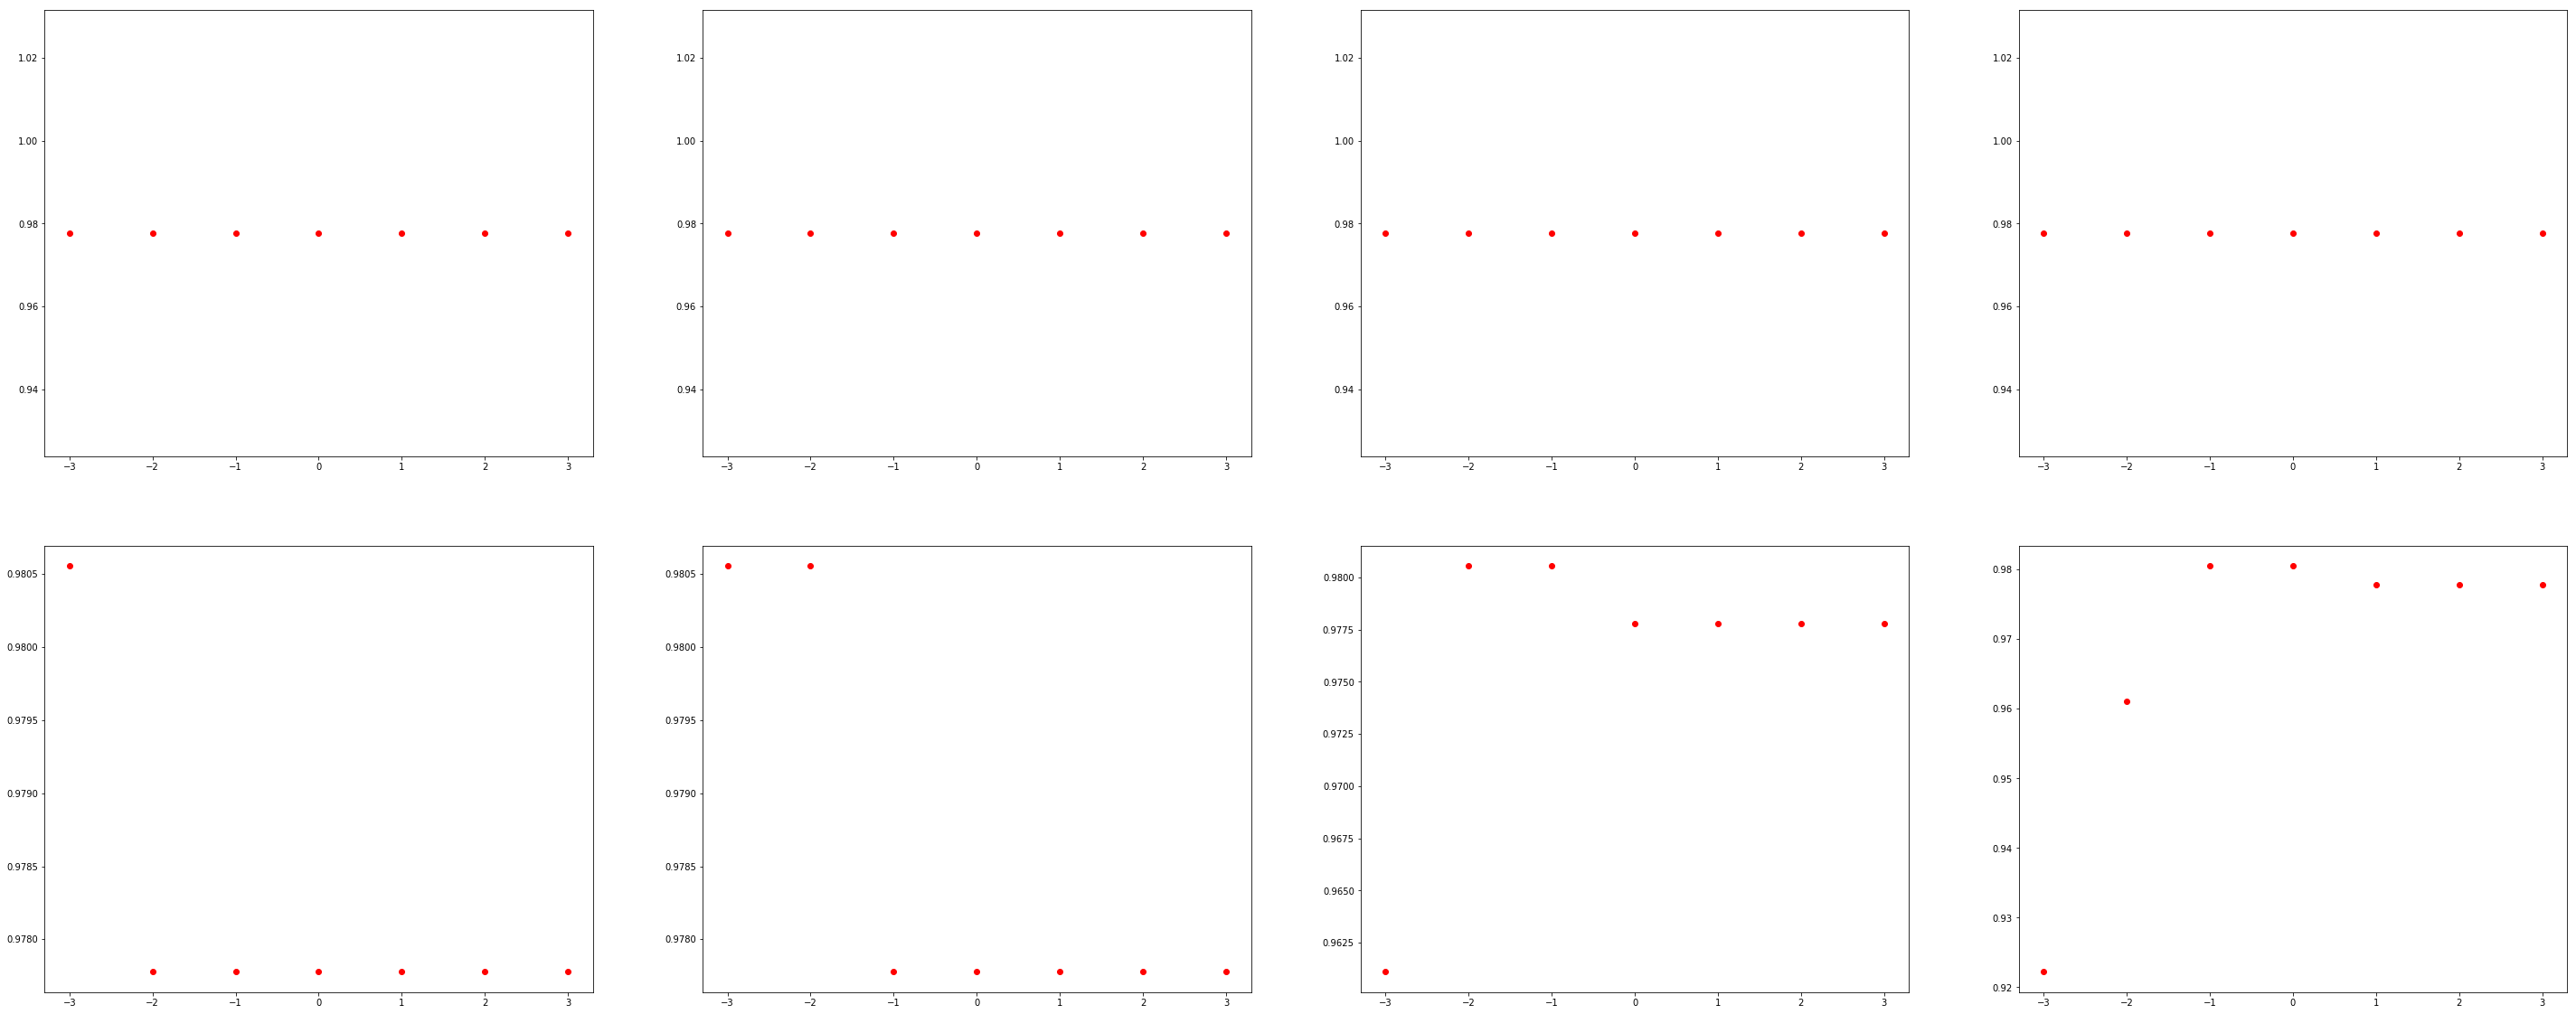

In [100]:
I = [-5,-4,-3,-2,-1,0,1,2]
J = [-3,-2,-1,0,1,2,3]
ct = 1
figure = plt.figure(figsize=(50,20))
for i in I:
    acc_m = []
    ax = plt.subplot(2,4,ct)
    for j in J:
        print("lambda= %s , lambda_u= %s" %(str(10**-i),str(10**-j)))
        acc_m.append(LapSVM(Mnist,10**-i,10**-j,verbose = False)[2])
    ct+=1
    plt.plot(J,acc_m,'ro')
plt.show()

### Question 16 : Complete the code in the box below

###### Describe your protocol here : 
-

-

-

In [101]:
P = [0.1,0.2,0.4,0.5,0.6,0.8,0.9]
err1 = []
err2 = []
err3 = []

for p in P:
    print("p= "+str(p))
    ##################################
    digits = load_digits()
    Mnist = semi_sup_dat(load_digits(), p,'Mnist')
    ##################################
    print("self training")
    print('self training with probabilistic distance ')
    err1.append(1-self_training(Mnist,5)[2][1])
    print(' ')
    print('self training with euclidiean distance ')
    self_training(Mnist,5,dist='eucl')
    ##################################
    err2.append(1-LapRLS(Mnist,0.01,1,plot = False)[2])
    ##################################
    err3.append(1-LapSVM(Mnist,0.01,1)[2])



p= 0.1
self training
self training with probabilistic distance 
accuracy on the train set for Mnist is equal to: 1.0
accuracy on the test set for Mnist is equal to: 0.991666666667
 
self training with euclidiean distance 
accuracy on the train set for Mnist is equal to: 0.965277777778
accuracy on the test set for Mnist is equal to: 0.991666666667
norme de alpha*: 1.66512828778
162
accuracy for Mnist is equal to: 0.994444444444
2.90877579656e-14
162
accuracy for Mnist is equal to: 1.0
p= 0.2
self training
self training with probabilistic distance 
accuracy on the train set for Mnist is equal to: 0.996527777778
accuracy on the test set for Mnist is equal to: 0.991666666667
 
self training with euclidiean distance 
accuracy on the train set for Mnist is equal to: 0.986111111111
accuracy on the test set for Mnist is equal to: 0.991666666667
norme de alpha*: 1.76274657215
162
accuracy for Mnist is equal to: 0.994444444444
2.65779767733e-14
162
accuracy for Mnist is equal to: 1.0
p= 0.4
self

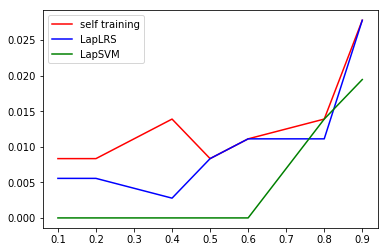

In [102]:
plt.plot(P,err1,'r',label = "self training")
plt.plot(P,err2,'b',label = "LapLRS")
plt.plot(P,err3,'g',label = "LapSVM")
plt.legend()
plt.show()

From the graph above we can see that the three algorithms are below 5% of error for all percentage of unlballed data.
we can also see that the LapSVM has better results overall. In time of computation However it's the worst of all.